In [1]:
import time
from IPython import display

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import random
%matplotlib inline

In [2]:
# Get variables
data = pd.read_csv('data/graphicCards.csv')
data.head()

,builder,chipset,frequency (MHz),boostFreq (MHz),overclok,bus,memory (Go),interfaceMem (bits),video memory freq (MHz),memory type,stream procs,direct X (max),multi GPU,consumption (W),price (euros)
0,amd,amd,625.0,NaN,no,PCI Express 2.0 16x,1.0,64,667.0,DDR3,160.0,11.0,NaN,18.0,37.94
1,asus,amd,625.0,NaN,no,PCI Express 2.0 16x,1.0,64,600.0,GDDR3,160.0,11.0,CrossFireX,19.0,39.95
2,msi,nvidia,954.0,NaN,no,PCI Express 2.0 16x,1.0,64,800.0,DDR3,192.0,12.0,NaN,19.0,39.95
3,sapphire,amd,625.0,NaN,no,PCI Express 2.0 16x,1.0,64,667.0,DDR3,160.0,11.0,NaN,18.0,39.95
4,asus,nvidia,954.0,NaN,no,PCI Express 2.0 16x,1.0,64,800.0,GDDR5,192.0,12.0,NaN,19.0,41.95


# Data exploration: Deal with missing data

In [3]:
# Missing variables (NaN)
print("There are empty columns? {}".format(data.isnull().all().any()))
print("There are columns with mising values? {}".format(data.isnull().any().any()))
print("\nWhich ones?:\n")
print(data[data.columns[data.isnull().any()].values].isnull().sum())

There are empty columns? False
There are columns with mising values? True

Which ones?:

chipset                      1
frequency (MHz)              4
boostFreq (MHz)             54
video memory freq (MHz)      1
stream procs                 3
direct X (max)               1
multi GPU                  100
consumption (W)              2
dtype: int64


In [4]:
# Take look at the chipset feature
print("Unique values: {}\n".format(data.chipset.unique()))
print("Count values: \n")
print(data.chipset.value_counts())

Unique values: ['amd' 'nvidia' nan]

Count values: 

nvidia    171
amd        74
Name: chipset, dtype: int64


In [5]:
# What is the nan chipset entry?
data[data.chipset.isnull()]

,builder,chipset,frequency (MHz),boostFreq (MHz),overclok,bus,memory (Go),interfaceMem (bits),video memory freq (MHz),memory type,stream procs,direct X (max),multi GPU,consumption (W),price (euros)
17,startech,NaN,NaN,NaN,no,PCI,0.016,32,NaN,DDR,NaN,NaN,NaN,2.0,69.95


In [6]:
# What can we do? We drop it here (not interesting for our purpose). Don't forget to update indexing
print("Data shape before droping: {}".format(data.shape))
data = data[data.chipset.notnull()]
data.index = np.arange(data.shape[0])
print("Data shape after droping: {}".format(data.shape))
print("\nWhat are columns with missing values now?:\n")
print(data[data.columns[data.isnull().any()].values].isnull().sum())

Data shape before droping: (246, 15)
Data shape after droping: (245, 15)

What are columns with missing values now?:

frequency (MHz)     3
boostFreq (MHz)    53
stream procs        2
multi GPU          99
consumption (W)     2
dtype: int64


In [7]:
# BoostFreq features is NaN when the constructor don't provide information.
# One can seen that as the given graphic card has not boosting option
# Solution is to set this value to frequency value if NaN (then we'll deal with NaN frequency entries)
data.loc[data['boostFreq (MHz)'].isnull(),'boostFreq (MHz)'] = data.loc[data['boostFreq (MHz)'].isnull(),
                                                                        'frequency (MHz)']
print("\nWhat are columns with missing values now?:\n")
print(data[data.columns[data.isnull().any()].values].isnull().sum())


What are columns with missing values now?:

frequency (MHz)     3
boostFreq (MHz)     3
stream procs        2
multi GPU          99
consumption (W)     2
dtype: int64


In [8]:
# What about the multi GPU?
print("Unique values: {}\n".format(data['multi GPU'].unique()))
print("Count values: \n")
print(data['multi GPU'].value_counts())

Unique values: [nan 'CrossFireX' 'SLI']

Count values: 

SLI           75
CrossFireX    71
Name: multi GPU, dtype: int64


In [9]:
# SLI is the nvidia multi GPU technology while CrossFireX is the AMD one
# As distinction beetween AMD and Nvidia is given with chipset features, 
#    one could transform multi GPU feature to a boolean one:
#       - True if card has multi GPU technology (SLI or CrossFireX)
#       - False if not (NaN values)
data['multi GPU'] = data['multi GPU'].notnull()
print("multi GPU feature exemples: {}\n".format(data['multi GPU'].values[:10]))
print("What are columns with missing values now?:\n")
print(data[data.columns[data.isnull().any()].values].isnull().sum())

multi GPU feature exemples: [False  True False False False False False  True  True False]

What are columns with missing values now?:

frequency (MHz)    3
boostFreq (MHz)    3
stream procs       2
consumption (W)    2
dtype: int64


In [10]:
# So, what about the last NaN values?
# Technicaly, frequency and boostFreq NaN corresponds to the same entries
# Print all NaN entries
data[data.isnull().any(axis=1)]

,builder,chipset,frequency (MHz),boostFreq (MHz),overclok,bus,memory (Go),interfaceMem (bits),video memory freq (MHz),memory type,stream procs,direct X (max),multi GPU,consumption (W),price (euros)
18,asus,nvidia,902.0,902.0,no,PCI Express 2.0 16x,2.048,64,1252.0,GDDR5,384.0,11.0,False,NaN,74.95
19,msi,nvidia,902.0,902.0,no,PCI Express 2.0 16x,2.000,64,800.0,DDR3,NaN,12.0,False,25.0,74.95
39,gigabyte,amd,1200.0,1200.0,yes,PCI Express 3.0 16x,2.048,128,1625.0,GDDR5,768.0,12.0,True,NaN,119.95
42,asus,amd,NaN,NaN,yes,PCI Express 3.0 16x,2.000,128,1750.0,GDDR5,1024.0,12.0,True,80.0,134.95
69,asus,amd,NaN,NaN,yes,PCI Express 3.0 16x,4.000,128,1750.0,GDDR5,1024.0,12.0,True,80.0,179.95
71,asus,amd,NaN,NaN,yes,PCI Express 3.0 16x,4.000,128,1750.0,GDDR5,1024.0,12.0,True,90.0,184.96
114,msi,nvidia,1544.0,1759.0,yes,PCI Express 3.0 16x,6.000,192,8008.0,GDDR5,NaN,12.0,False,120.0,344.95


In [11]:
# There are several way to deal with that:
#       -> find information from other source (constructor site)
#       -> estimate missing values from data (could introduce biais!)
#       -> drop them (only if there represent a small part of data)
#
# Here we'll drop them for simplicity
print("We'll drop {} entries ({}%)".format(data[data.isnull().any(axis=1)].shape[0],
                                           (data[data.isnull().any(axis=1)].shape[0]/data.shape[0])*100))
print("\nData shape before droping: {}".format(data.shape))
data = data[data.notnull().all(axis=1)]
data.index = np.arange(data.shape[0])
print("Data shape after droping: {}\n".format(data.shape))
print("There are empty columns? {}".format(data.isnull().all().any()))
print("There are columns with mising values? {}".format(data.isnull().any().any()))

We'll drop 7 entries (2.857142857142857%)

Data shape before droping: (245, 15)
Data shape after droping: (238, 15)

There are empty columns? False
There are columns with mising values? False


# Data exploration: Features engineering

In [12]:
# Let print first rows of our data
data.head()

,builder,chipset,frequency (MHz),boostFreq (MHz),overclok,bus,memory (Go),interfaceMem (bits),video memory freq (MHz),memory type,stream procs,direct X (max),multi GPU,consumption (W),price (euros)
0,amd,amd,625.0,625.0,no,PCI Express 2.0 16x,1.0,64,667.0,DDR3,160.0,11.0,False,18.0,37.94
1,asus,amd,625.0,625.0,no,PCI Express 2.0 16x,1.0,64,600.0,GDDR3,160.0,11.0,True,19.0,39.95
2,msi,nvidia,954.0,954.0,no,PCI Express 2.0 16x,1.0,64,800.0,DDR3,192.0,12.0,False,19.0,39.95
3,sapphire,amd,625.0,625.0,no,PCI Express 2.0 16x,1.0,64,667.0,DDR3,160.0,11.0,False,18.0,39.95
4,asus,nvidia,954.0,954.0,no,PCI Express 2.0 16x,1.0,64,800.0,GDDR5,192.0,12.0,False,19.0,41.95


In [13]:
# How to transform our categorial features?
# Several things are possible, let's try to transform them as boolean features
#  -> First get number of uniques values for each categorials features
categorialFeatures = ['builder','chipset','overclok','bus','memory type','direct X (max)']
for feature in categorialFeatures:
    print("\n{}: ({} unique values)".format(feature, len(data[feature].unique())))
    print(data[feature].unique())


builder: (8 unique values)
['amd' 'asus' 'msi' 'sapphire' 'gigabyte' 'evga' 'zotac' 'inno3D']

chipset: (2 unique values)
['amd' 'nvidia']

overclok: (3 unique values)
['no' 'no ' 'yes']

bus: (3 unique values)
['PCI Express 2.0 16x' 'PCI Express 2.0 8x' 'PCI Express 3.0 16x']

memory type: (7 unique values)
['DDR3' 'GDDR3' 'GDDR5' 'DDR4' 'GDRR5' 'GDDR5X' 'HBM2']

direct X (max): (3 unique values)
[11.  12.  11.2]


In [14]:
# Here, we spot an error in overclok columns: 'no ' with a space. 
# It seems to be a typo, let replace it by correct 'no' value
data.loc[data.overclok == 'no ','overclok'] = 'no'
 
# Other problem: directX == 11.2 -> set it to 11
data.loc[data['direct X (max)'] == 11.2,'direct X (max)'] = 11

for feature in categorialFeatures:
    print("\n{}: ({} unique values)".format(feature, len(data[feature].unique())))
    print(data[feature].unique())


builder: (8 unique values)
['amd' 'asus' 'msi' 'sapphire' 'gigabyte' 'evga' 'zotac' 'inno3D']

chipset: (2 unique values)
['amd' 'nvidia']

overclok: (2 unique values)
['no' 'yes']

bus: (3 unique values)
['PCI Express 2.0 16x' 'PCI Express 2.0 8x' 'PCI Express 3.0 16x']

memory type: (7 unique values)
['DDR3' 'GDDR3' 'GDDR5' 'DDR4' 'GDRR5' 'GDDR5X' 'HBM2']

direct X (max): (2 unique values)
[11. 12.]


In [15]:
# Let's create our boolean features
for feature in categorialFeatures:
    for value in data[feature].unique():
        newFeatureName = str(feature) + "_" + str(value)
        data[newFeatureName] = data[feature] == value
    data.drop(feature,axis=1,inplace=True)
    
print("New data shape: {}".format(data.shape))

New data shape: (238, 33)


In [17]:
# Now replace boolean values (True, False) by numeric number (1, 0)
data[data.columns[data.dtypes == bool]] = data[data.columns[data.dtypes == bool]] * 1

data.head()

,frequency (MHz),boostFreq (MHz),memory (Go),interfaceMem (bits),video memory freq (MHz),stream procs,multi GPU,consumption (W),price (euros),builder_amd,...,bus_PCI Express 3.0 16x,memory type_DDR3,memory type_GDDR3,memory type_GDDR5,memory type_DDR4,memory type_GDRR5,memory type_GDDR5X,memory type_HBM2,direct X (max)_11.0,direct X (max)_12.0
0,625.0,625.0,1.0,64,667.0,160.0,0,18.0,37.94,1,...,0,1,0,0,0,0,0,0,1,0
1,625.0,625.0,1.0,64,600.0,160.0,1,19.0,39.95,0,...,0,0,1,0,0,0,0,0,1,0
2,954.0,954.0,1.0,64,800.0,192.0,0,19.0,39.95,0,...,0,1,0,0,0,0,0,0,0,1
3,625.0,625.0,1.0,64,667.0,160.0,0,18.0,39.95,0,...,0,1,0,0,0,0,0,0,1,0
4,954.0,954.0,1.0,64,800.0,192.0,0,19.0,41.95,0,...,0,0,0,1,0,0,0,0,0,1


In [18]:
# Last feature engineering transformation: replace boostFreq feature by the diff beetween frequency and boostFreq
data['boostFreqIncr'] = data['boostFreq (MHz)'] - data['frequency (MHz)']
data.drop('boostFreq (MHz)',axis=1,inplace=True)

In [19]:
# Last things, make sure index are correct
data.index = np.arange(data.shape[0])
# That's ok now! Let print new data shape and first rows
print("Data shape = {}".format(data.shape))
data.head()

Data shape = (238, 33)


,frequency (MHz),memory (Go),interfaceMem (bits),video memory freq (MHz),stream procs,multi GPU,consumption (W),price (euros),builder_amd,builder_asus,...,memory type_DDR3,memory type_GDDR3,memory type_GDDR5,memory type_DDR4,memory type_GDRR5,memory type_GDDR5X,memory type_HBM2,direct X (max)_11.0,direct X (max)_12.0,boostFreqIncr
0,625.0,1.0,64,667.0,160.0,0,18.0,37.94,1,0,...,1,0,0,0,0,0,0,1,0,0.0
1,625.0,1.0,64,600.0,160.0,1,19.0,39.95,0,1,...,0,1,0,0,0,0,0,1,0,0.0
2,954.0,1.0,64,800.0,192.0,0,19.0,39.95,0,0,...,1,0,0,0,0,0,0,0,1,0.0
3,625.0,1.0,64,667.0,160.0,0,18.0,39.95,0,0,...,1,0,0,0,0,0,0,1,0,0.0
4,954.0,1.0,64,800.0,192.0,0,19.0,41.95,0,1,...,0,0,1,0,0,0,0,0,1,0.0


# Normalize dataset

In [20]:
# Let store our Y vector (price) in separate Series
Y = data['price (euros)']
data.drop('price (euros)',axis=1,inplace=True)

In [21]:
# Before normalize inputs, let's print a description of non-boolean features
data.describe()

,frequency (MHz),memory (Go),interfaceMem (bits),video memory freq (MHz),stream procs,multi GPU,consumption (W),builder_amd,builder_asus,builder_msi,...,memory type_DDR3,memory type_GDDR3,memory type_GDDR5,memory type_DDR4,memory type_GDRR5,memory type_GDDR5X,memory type_HBM2,direct X (max)_11.0,direct X (max)_12.0,boostFreqIncr
count,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,...,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000
mean,1383.399160,5.609647,284.369748,3514.352941,1696.268908,0.596639,141.357143,0.021008,0.260504,0.235294,...,0.046218,0.008403,0.722689,0.008403,0.004202,0.163866,0.046218,0.050420,0.949580,123.344538
std,243.725732,3.002020,397.880967,3469.831447,1111.672930,0.491606,80.899027,0.143714,0.439835,0.425076,...,0.210400,0.091476,0.448615,0.091476,0.064820,0.370934,0.210400,0.219272,0.219272,93.185169
min,625.000000,1.000000,64.000000,600.000000,96.000000,0.000000,18.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,1276.500000,3.000000,128.000000,1750.000000,768.000000,0.000000,75.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000
50%,1411.000000,6.000000,192.000000,2000.000000,1280.000000,1.000000,120.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,114.000000
75%,1581.500000,8.000000,256.000000,2044.250000,2432.000000,1.000000,180.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,202.000000
max,1797.000000,11.000000,2048.000000,11400.000000,4096.000000,1.000000,350.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,379.000000


In [22]:
# As boostFreqIncr features has negatives values, in MinMax scaler is not a good thing to do.
# Instead we'll use a standard scaler (remove mean, divide by standard deviation)
data[data.columns[data.dtypes != object]] = (data[data.columns[data.dtypes != object]] - \
                                             data[data.columns[data.dtypes != object]].mean()) / \
                                            data[data.columns[data.dtypes != object]].std()
data.head()

,frequency (MHz),memory (Go),interfaceMem (bits),video memory freq (MHz),stream procs,multi GPU,consumption (W),builder_amd,builder_asus,builder_msi,...,memory type_DDR3,memory type_GDDR3,memory type_GDDR5,memory type_DDR4,memory type_GDRR5,memory type_GDDR5X,memory type_HBM2,direct X (max)_11.0,direct X (max)_12.0,boostFreqIncr
0,-3.111691,-1.535515,-0.553858,-0.820603,-1.381943,-1.213652,-1.524829,6.812063,-0.592277,-0.553534,...,4.533173,-0.091864,-1.610935,-0.091864,-0.06482,-0.441765,-0.219669,4.330612,-4.330612,-1.32365
1,-3.111691,-1.535515,-0.553858,-0.839912,-1.381943,0.820497,-1.512467,-0.146182,1.681304,-0.553534,...,-0.219669,10.839936,-1.610935,-0.091864,-0.06482,-0.441765,-0.219669,4.330612,-4.330612,-1.32365
2,-1.761813,-1.535515,-0.553858,-0.782272,-1.353158,-1.213652,-1.512467,-0.146182,-0.592277,1.798984,...,4.533173,-0.091864,-1.610935,-0.091864,-0.06482,-0.441765,-0.219669,-0.229944,0.229944,-1.32365
3,-3.111691,-1.535515,-0.553858,-0.820603,-1.381943,-1.213652,-1.524829,-0.146182,-0.592277,-0.553534,...,4.533173,-0.091864,-1.610935,-0.091864,-0.06482,-0.441765,-0.219669,4.330612,-4.330612,-1.32365
4,-1.761813,-1.535515,-0.553858,-0.782272,-1.353158,-1.213652,-1.512467,-0.146182,1.681304,-0.553534,...,-0.219669,-0.091864,0.618149,-0.091864,-0.06482,-0.441765,-0.219669,-0.229944,0.229944,-1.32365


In [23]:
# Add bias
data['x0'] = 1
data.head()

,frequency (MHz),memory (Go),interfaceMem (bits),video memory freq (MHz),stream procs,multi GPU,consumption (W),builder_amd,builder_asus,builder_msi,...,memory type_GDDR3,memory type_GDDR5,memory type_DDR4,memory type_GDRR5,memory type_GDDR5X,memory type_HBM2,direct X (max)_11.0,direct X (max)_12.0,boostFreqIncr,x0
0,-3.111691,-1.535515,-0.553858,-0.820603,-1.381943,-1.213652,-1.524829,6.812063,-0.592277,-0.553534,...,-0.091864,-1.610935,-0.091864,-0.06482,-0.441765,-0.219669,4.330612,-4.330612,-1.32365,1
1,-3.111691,-1.535515,-0.553858,-0.839912,-1.381943,0.820497,-1.512467,-0.146182,1.681304,-0.553534,...,10.839936,-1.610935,-0.091864,-0.06482,-0.441765,-0.219669,4.330612,-4.330612,-1.32365,1
2,-1.761813,-1.535515,-0.553858,-0.782272,-1.353158,-1.213652,-1.512467,-0.146182,-0.592277,1.798984,...,-0.091864,-1.610935,-0.091864,-0.06482,-0.441765,-0.219669,-0.229944,0.229944,-1.32365,1
3,-3.111691,-1.535515,-0.553858,-0.820603,-1.381943,-1.213652,-1.524829,-0.146182,-0.592277,-0.553534,...,-0.091864,-1.610935,-0.091864,-0.06482,-0.441765,-0.219669,4.330612,-4.330612,-1.32365,1
4,-1.761813,-1.535515,-0.553858,-0.782272,-1.353158,-1.213652,-1.512467,-0.146182,1.681304,-0.553534,...,-0.091864,0.618149,-0.091864,-0.06482,-0.441765,-0.219669,-0.229944,0.229944,-1.32365,1


# Train / test splitting

In [24]:
# We need to separate our dataset into two sub-sample:
#    -> train set: used to train the model (70%)
#    -> test set: to measure performances (30%)
# Let pick random entries
index = data.index.values.copy()
random.shuffle(index)

X_train = data.loc[index[:int(len(index)*0.7)]]
X_test = data.loc[index[int(len(index)*0.7):]]
Y_train = Y.loc[index[:int(len(index)*0.7)]]
Y_test = Y.loc[index[int(len(index)*0.7):]]

print("Train set X shape: {}".format(X_train.shape))
print("Train set Y shape: {}".format(Y_train.shape))
print("Test set X shape: {}".format(X_test.shape))
print("Test set X shape: {}".format(Y_test.shape))

Train set X shape: (166, 33)
Train set Y shape: (166,)
Test set X shape: (72, 33)
Test set X shape: (72,)


# Linear Regression

In [25]:
# Définir notre hypothèse (fonction)
def hypothesis(x,theta):
    return np.dot(x,theta)

# On définit notre fonction de coût: somme quadratique (eg: on somme les carré)
def costFunction(y,yhat):
    return np.square(yhat - y).sum()/(2*y.shape[0])

# On génère aléatoirement le vecteur des paramétres de notre modèle
theta = np.random.rand(X_train.shape[1])-0.5

# Compute cost function value for this initialized model
yhat = hypothesis(X_train,theta)
print("Cost Function value = {}".format(costFunction(Y_train,yhat)))

Cost Function value = 130478.96869971823


In [26]:
# Let define some usefull function
def costFctDeriv(x,y,yhat):
    return ((yhat - y)*x.T).sum(axis=1)/y.shape[0]

def gradDescent(x,y,yhat,alpha):
    return -alpha*costFctDeriv(x,y,yhat)

def plotCostFunctionEvol(ax,gradDescentEvol):
    ax.plot(np.arange(gradDescentEvol.shape[0]),gradDescentEvol.Jtrain,label='J(train)')
    ax.plot(np.arange(gradDescentEvol.shape[0]),gradDescentEvol.Jtest,label='J(test)')
    ax.legend(fontsize=15)
    
def errorFct(y,yhat):
    return np.abs(yhat - y).sum()/(y.shape[0])

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


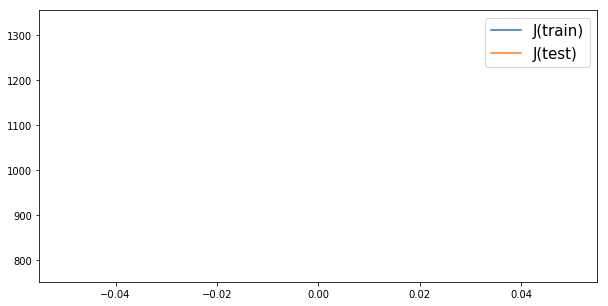

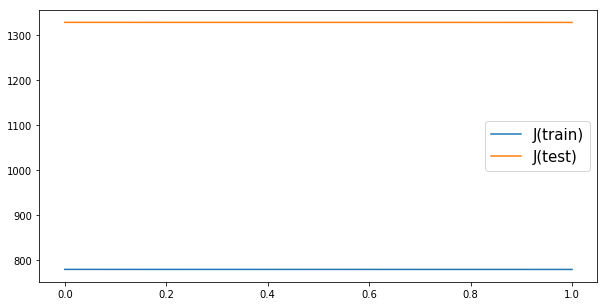

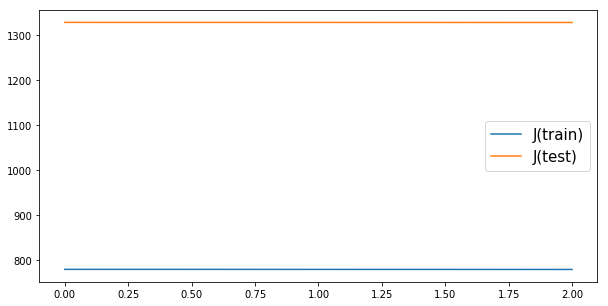

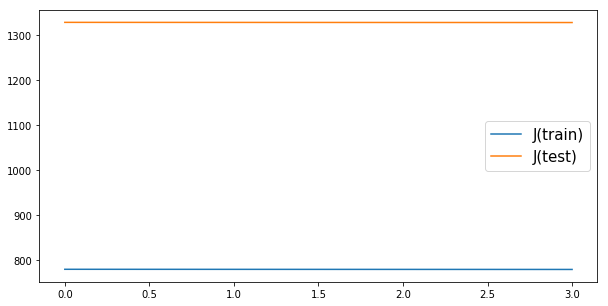

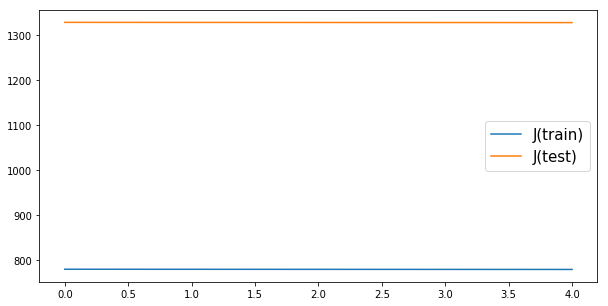

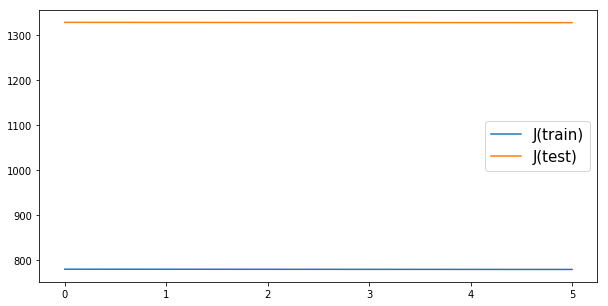

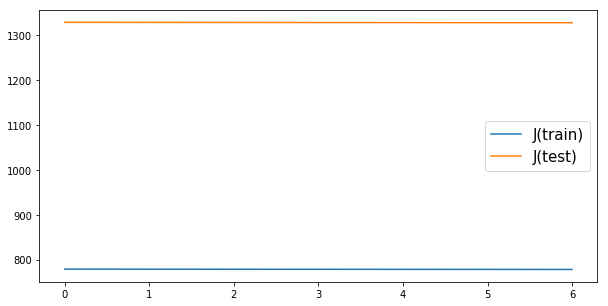

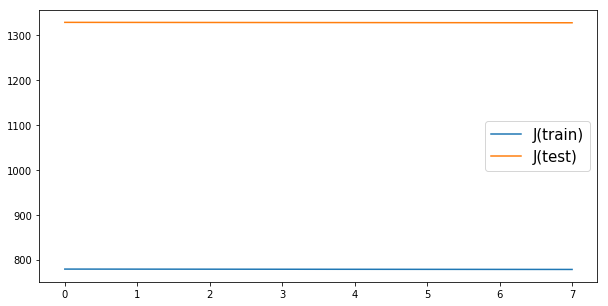

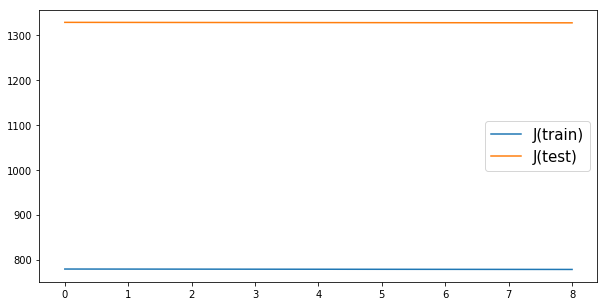

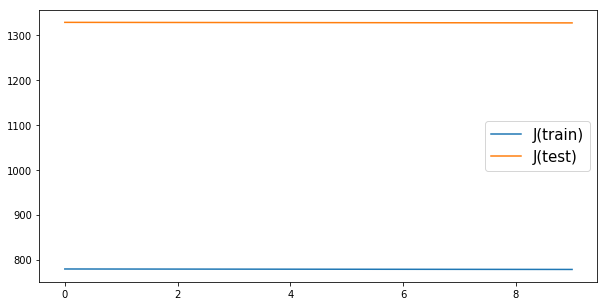

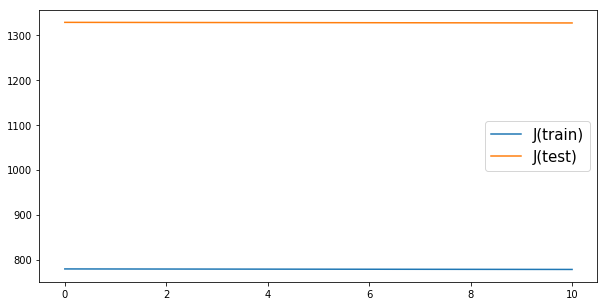

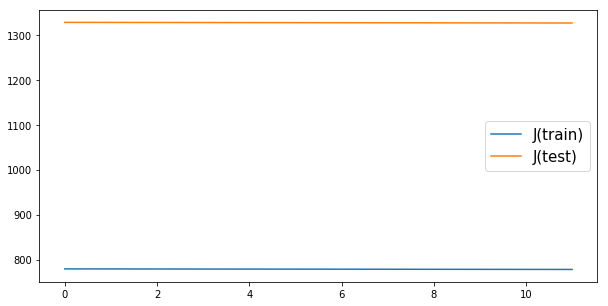

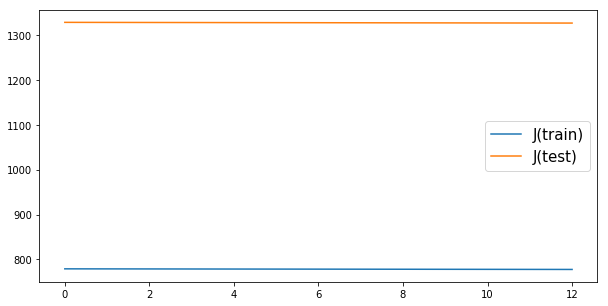

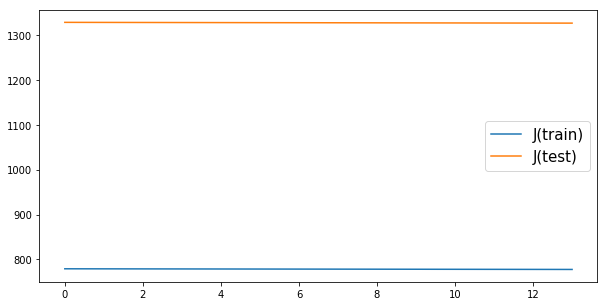

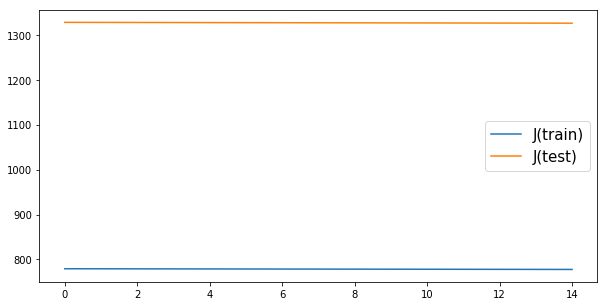

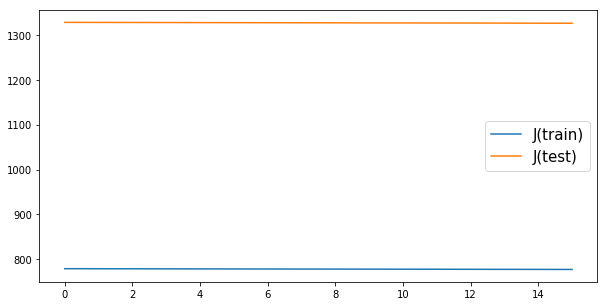

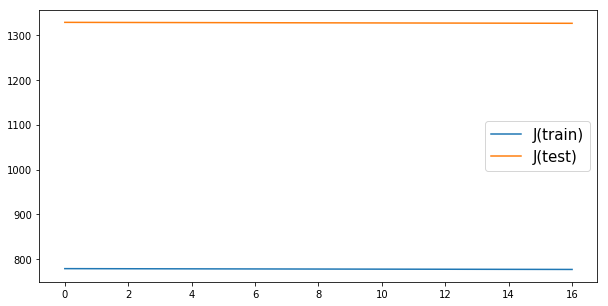

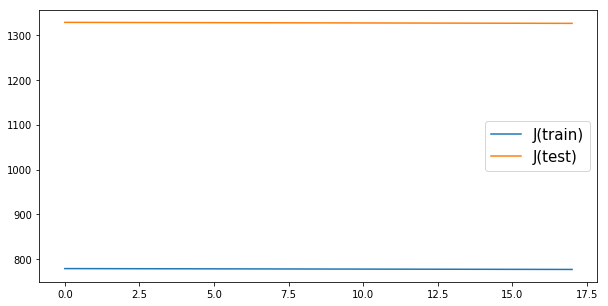

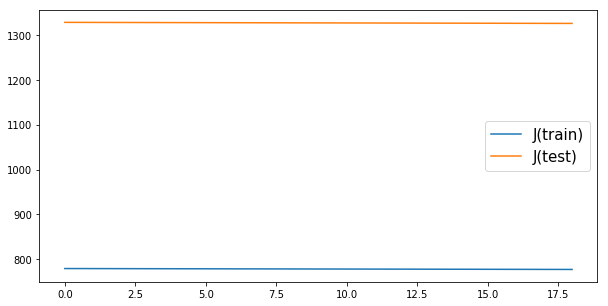

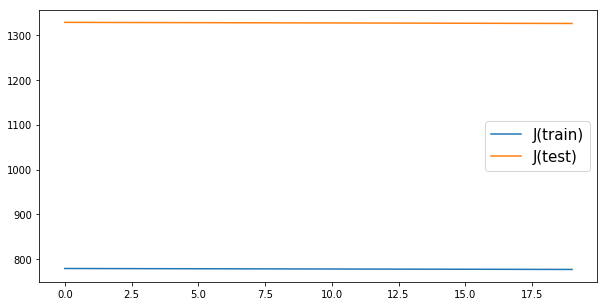

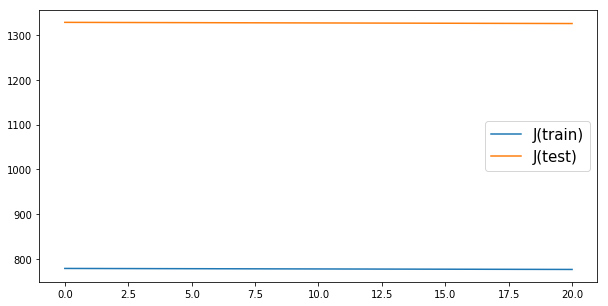

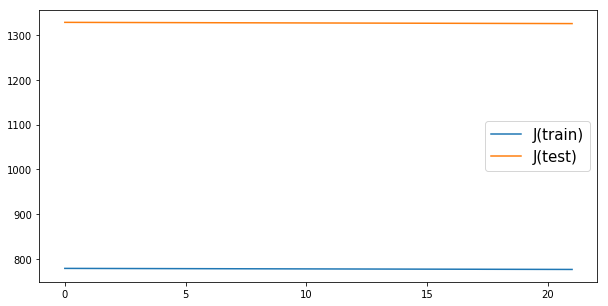

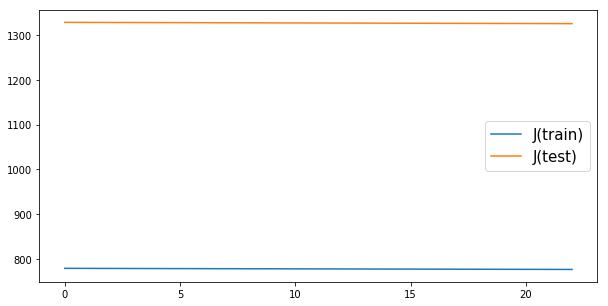

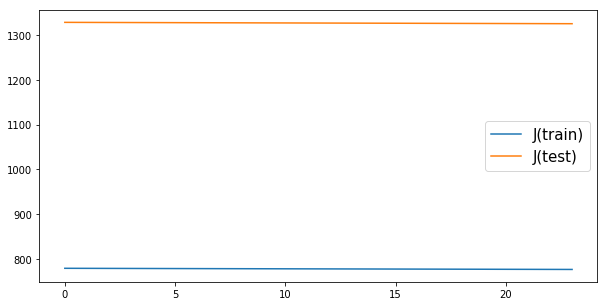

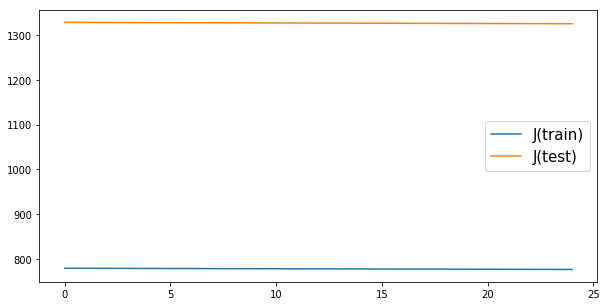

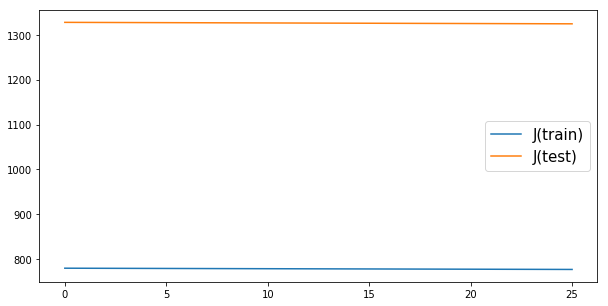

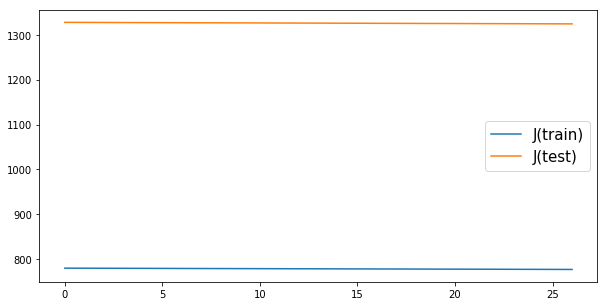

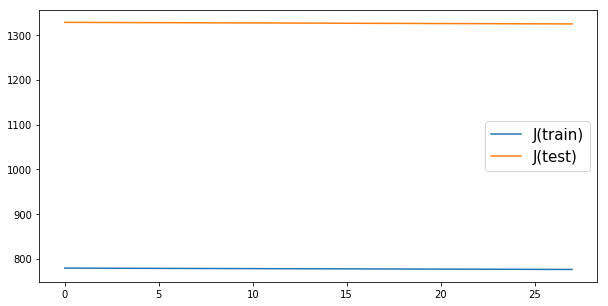

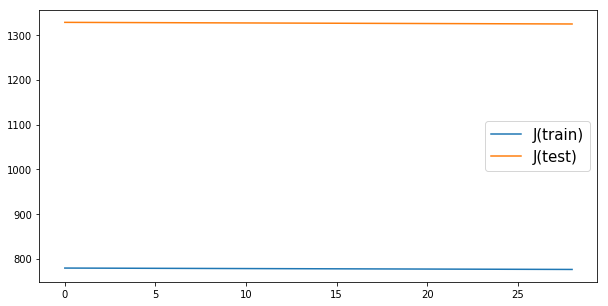

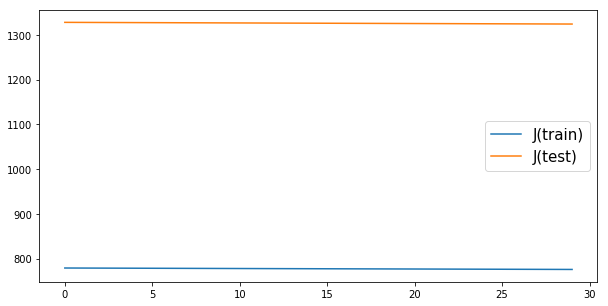

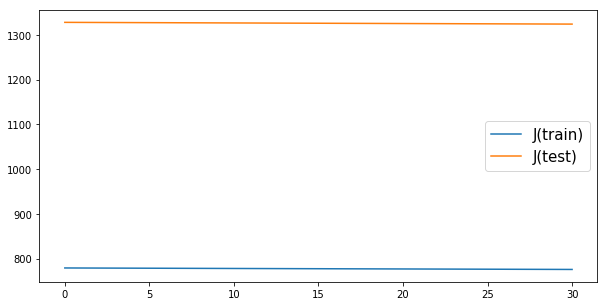

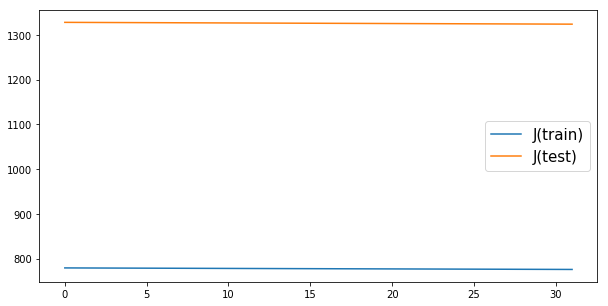

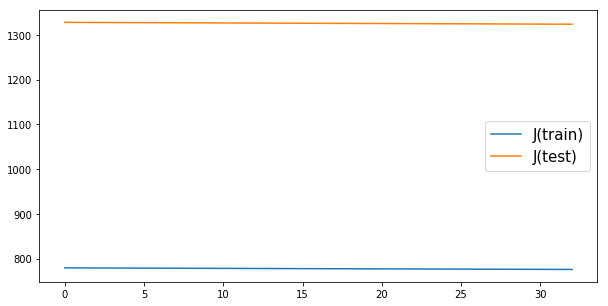

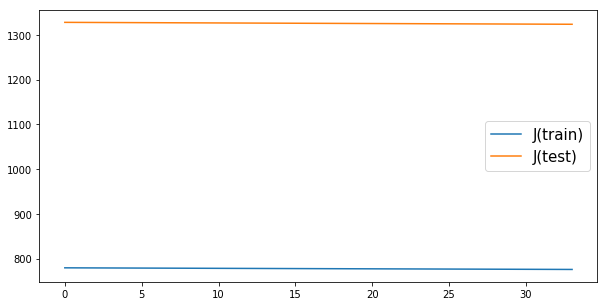

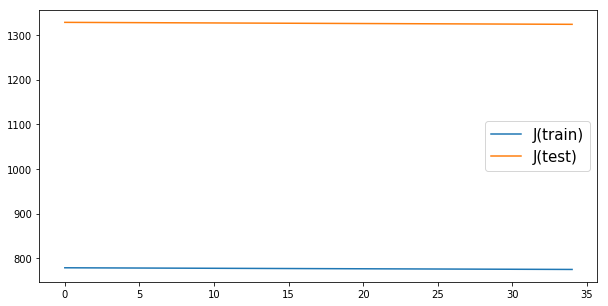

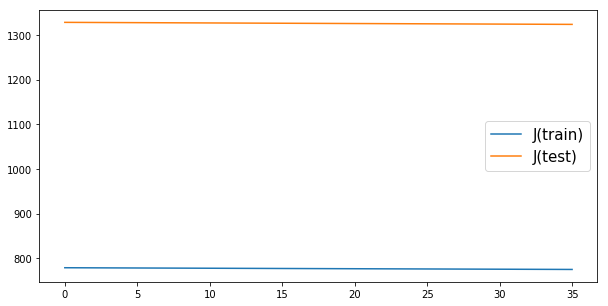

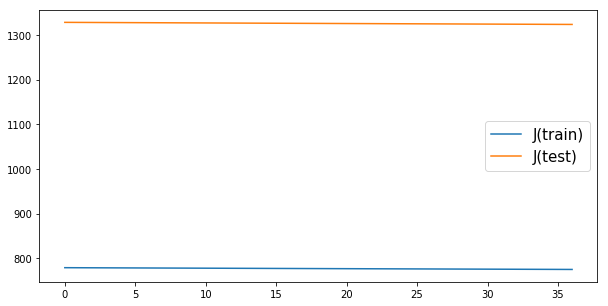

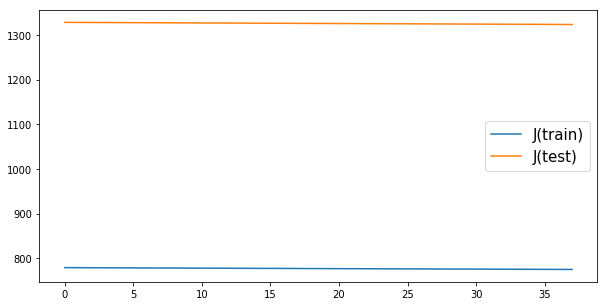

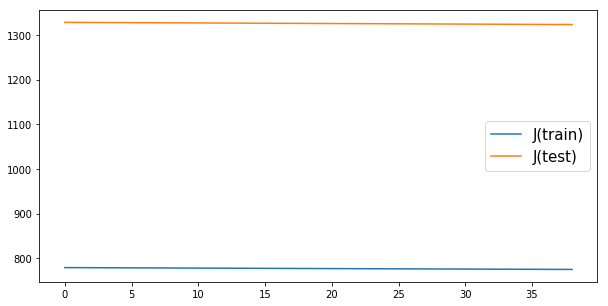

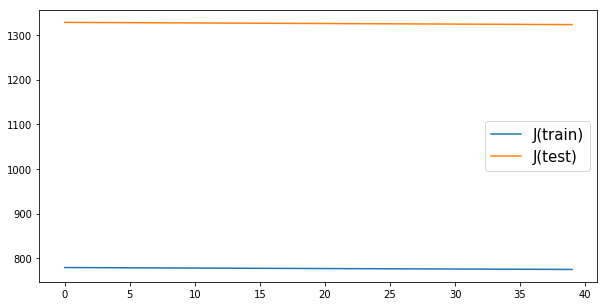

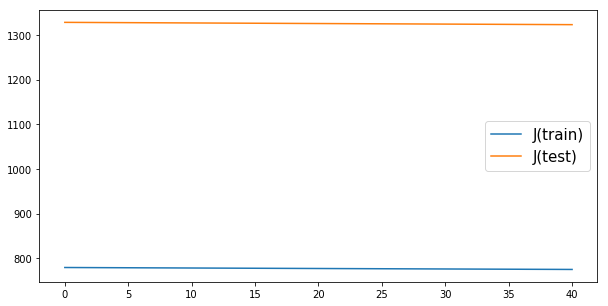

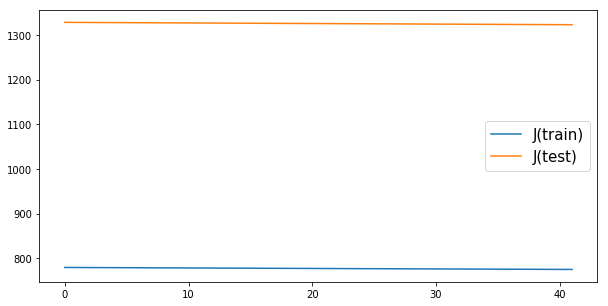

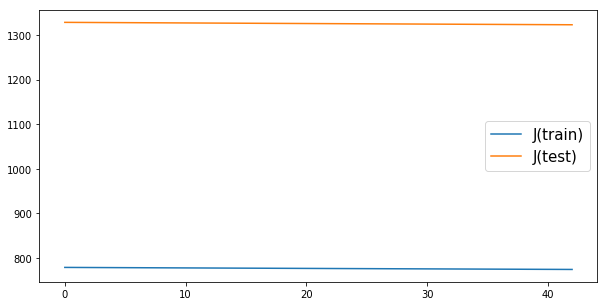

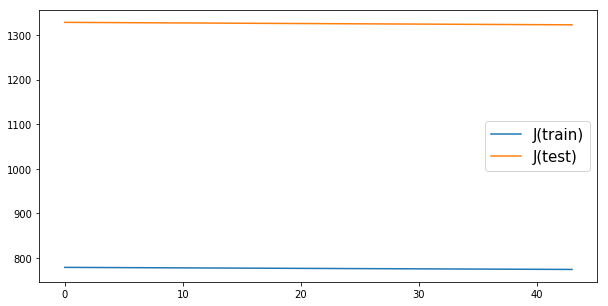

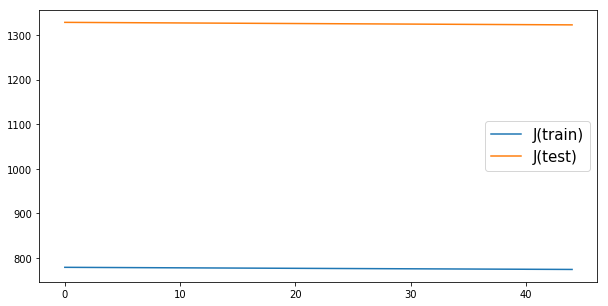

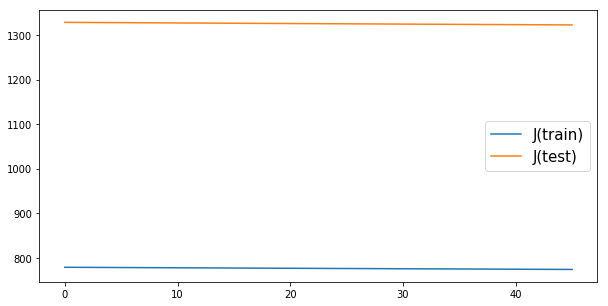

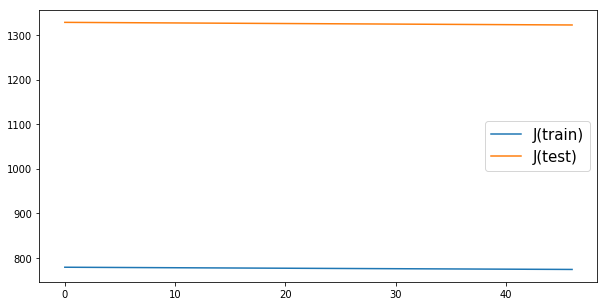

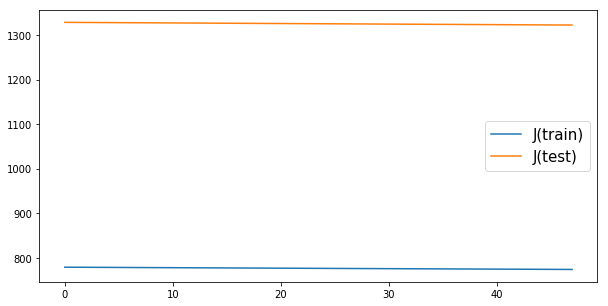

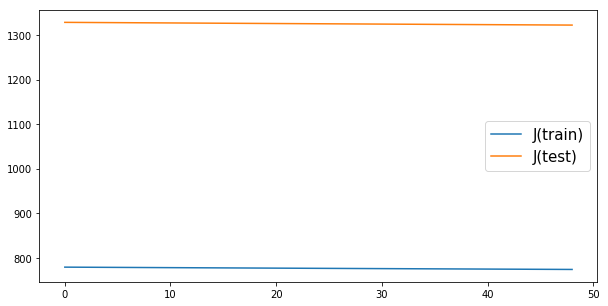

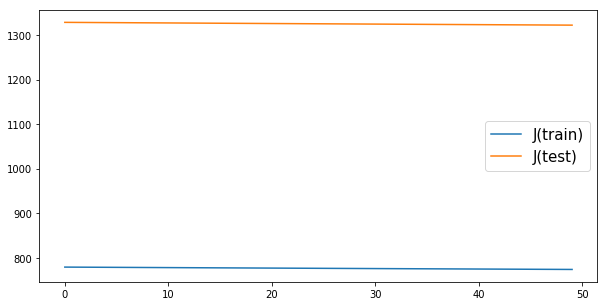

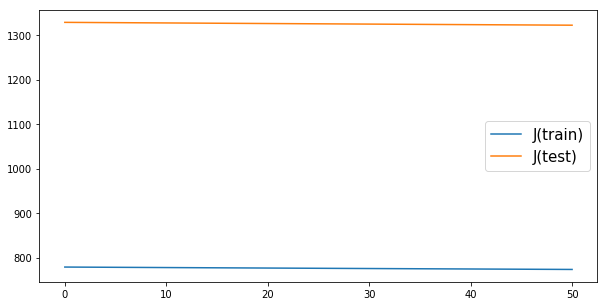

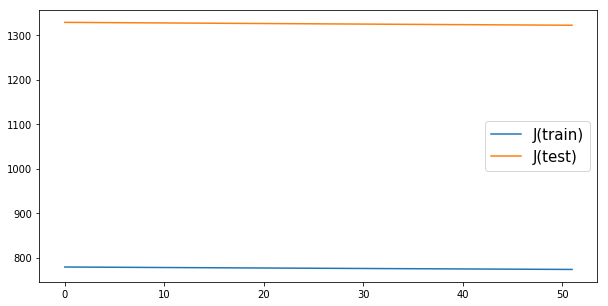

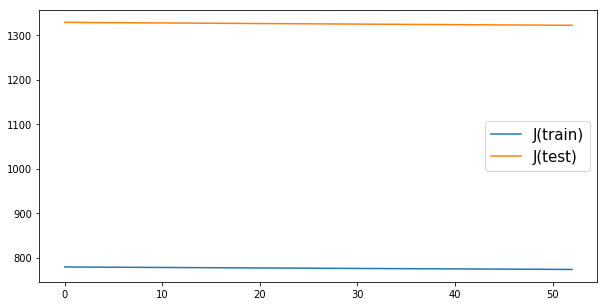

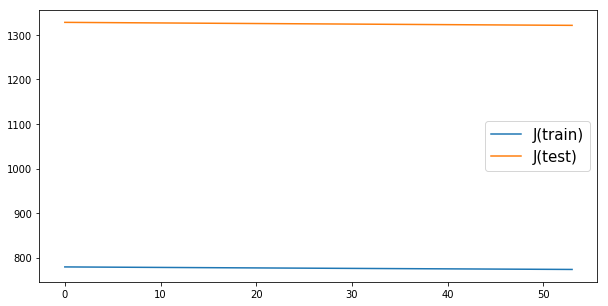

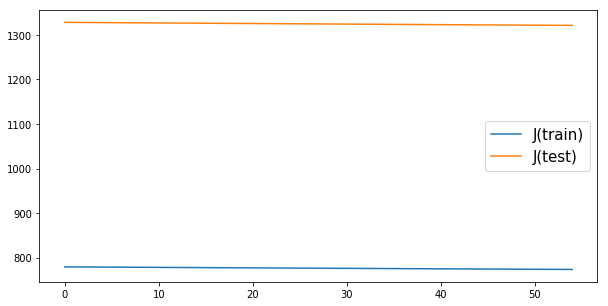

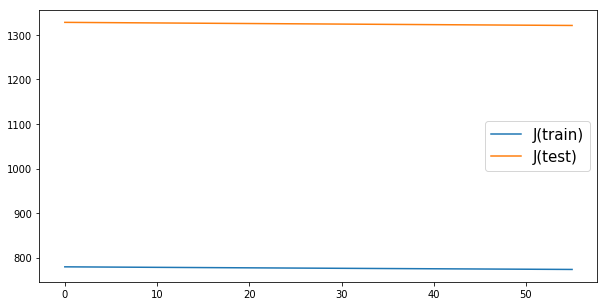

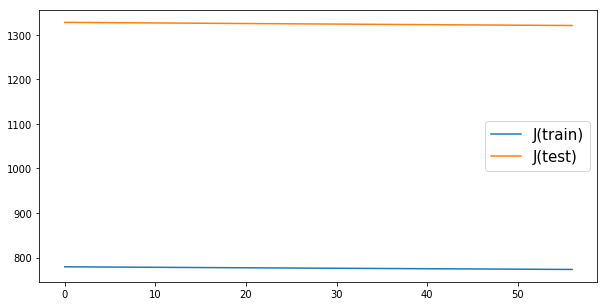

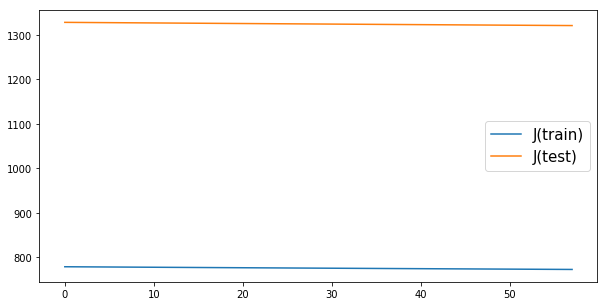

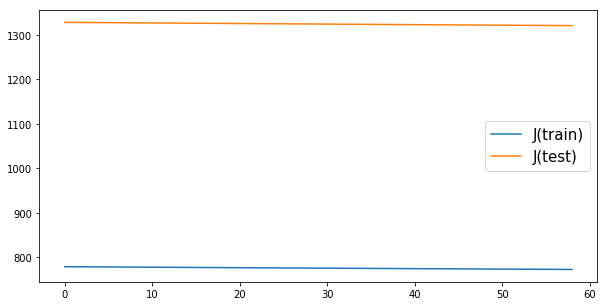

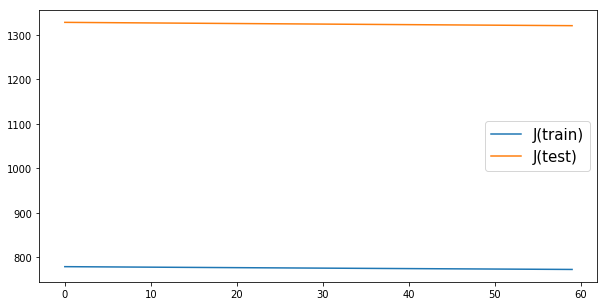

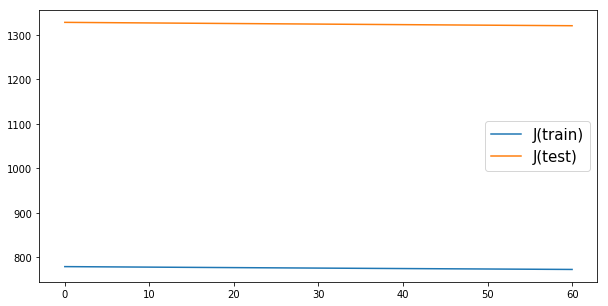

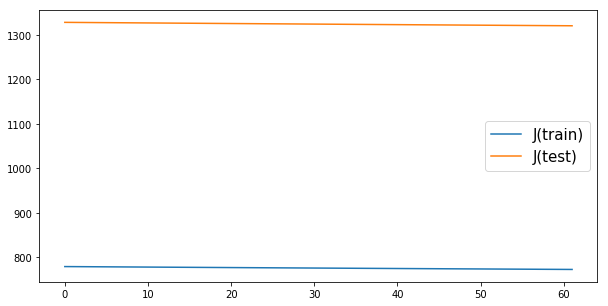

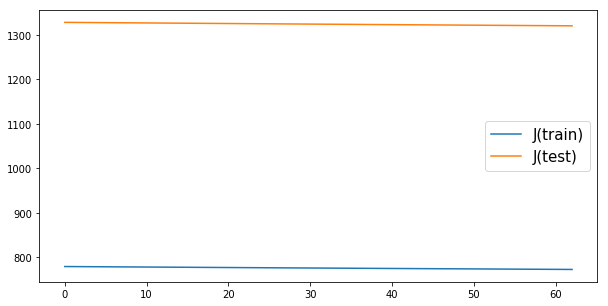

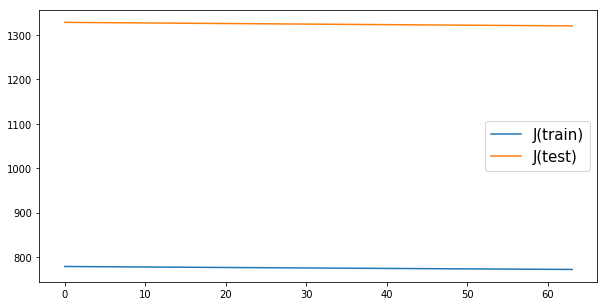

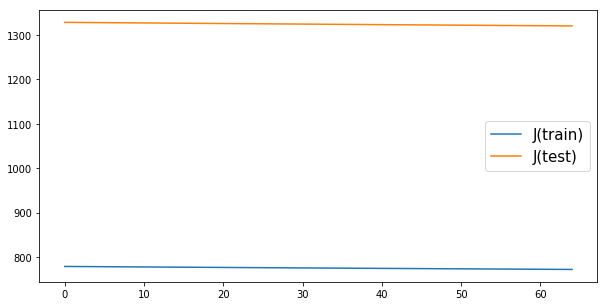

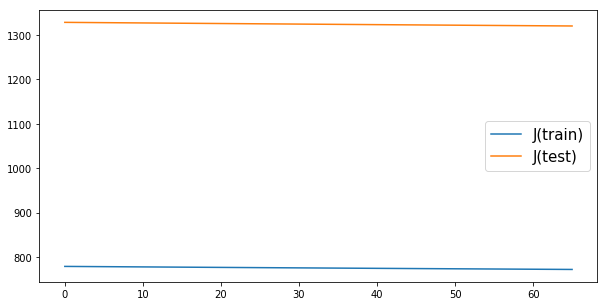

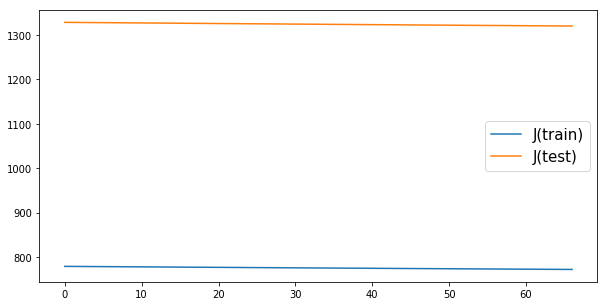

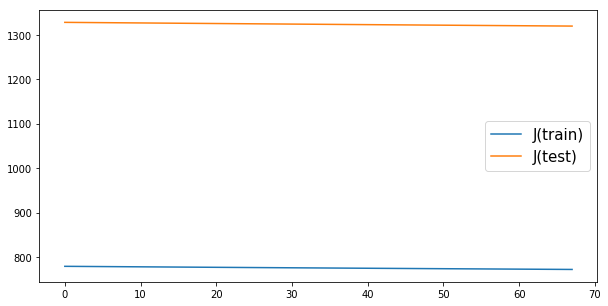

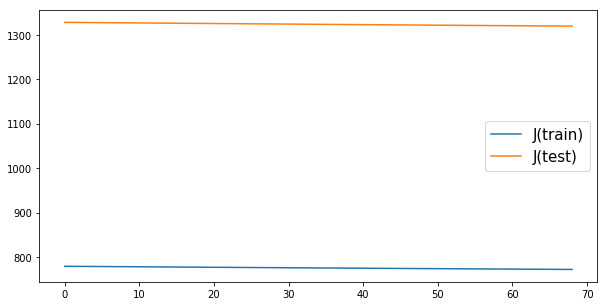

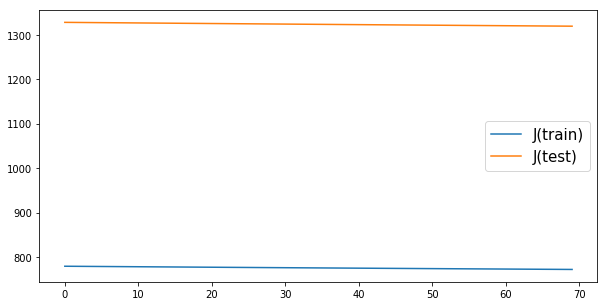

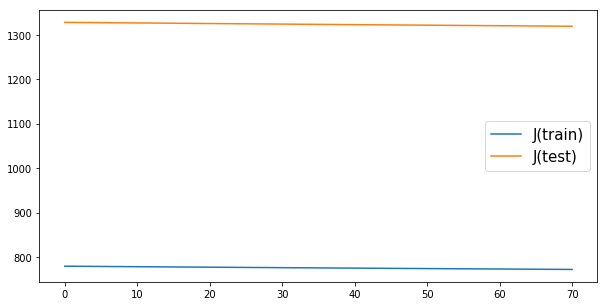

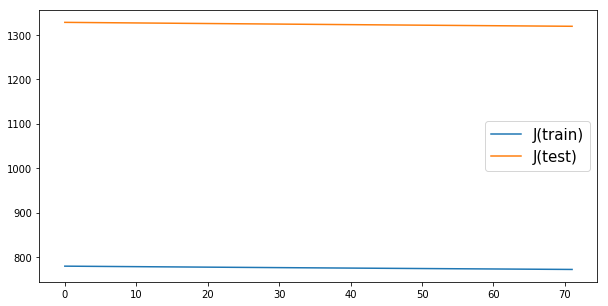

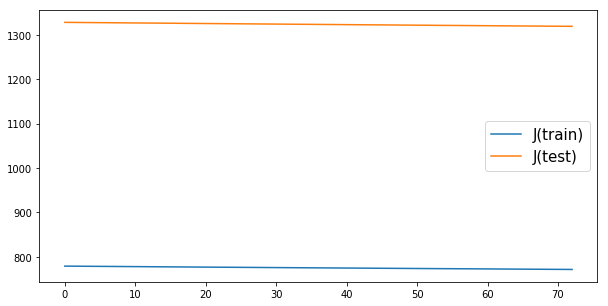

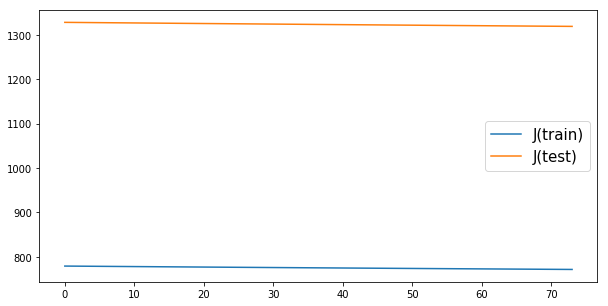

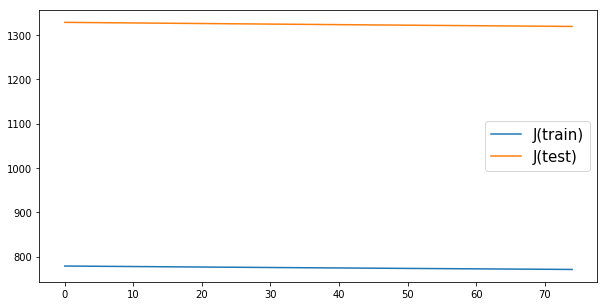

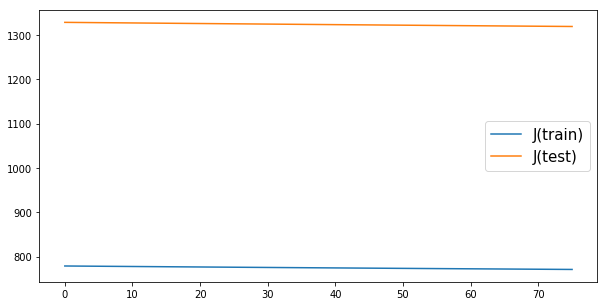

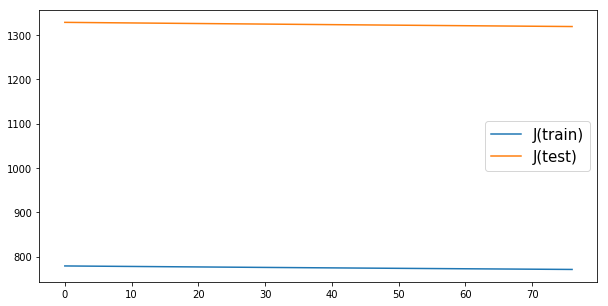

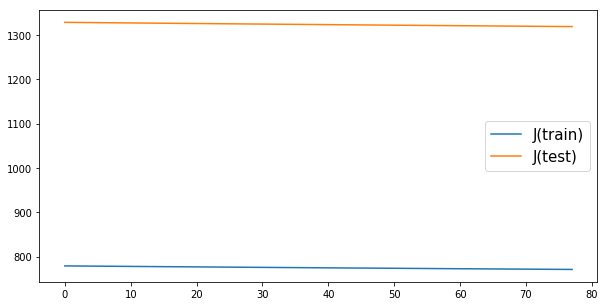

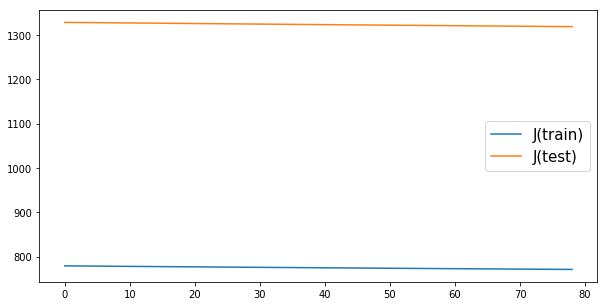

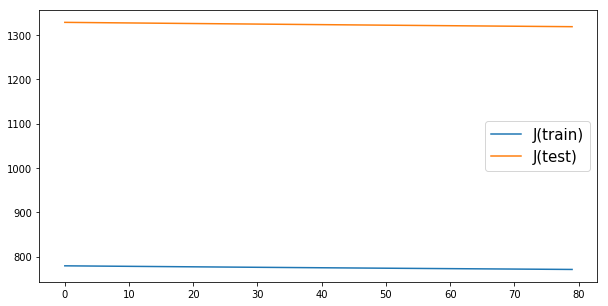

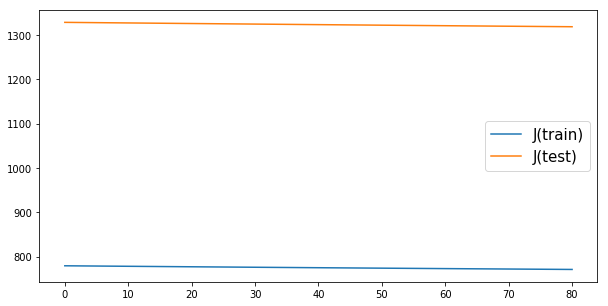

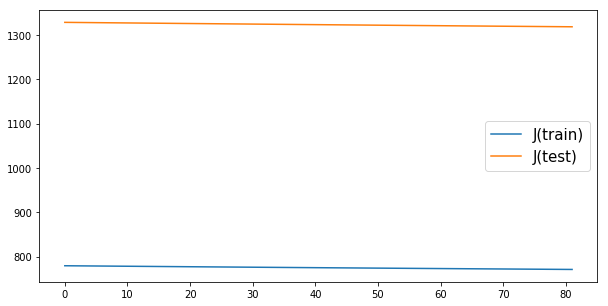

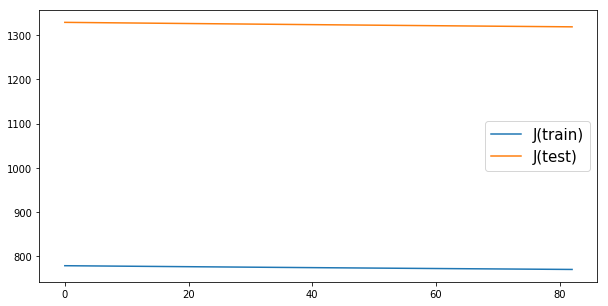

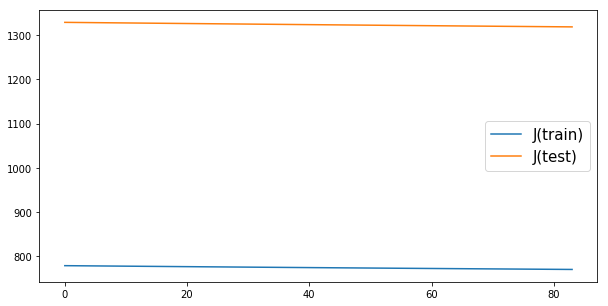

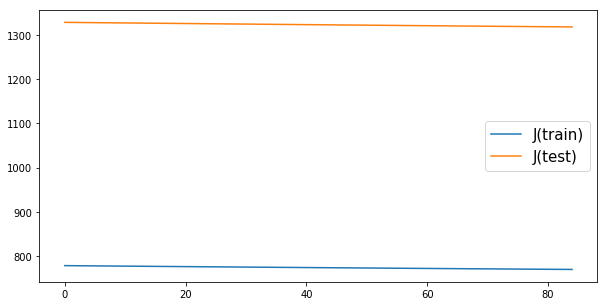

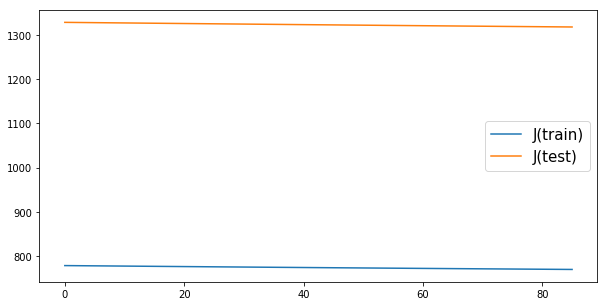

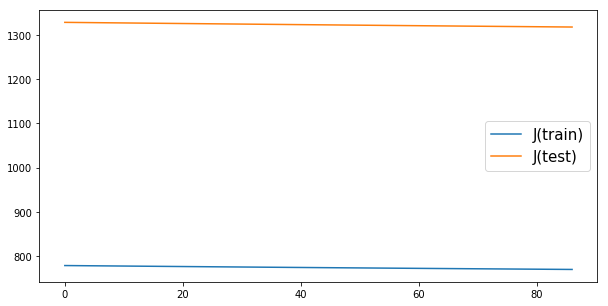

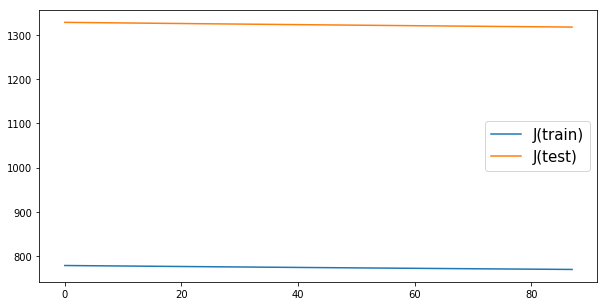

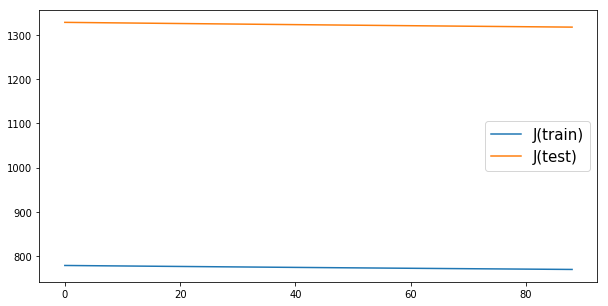

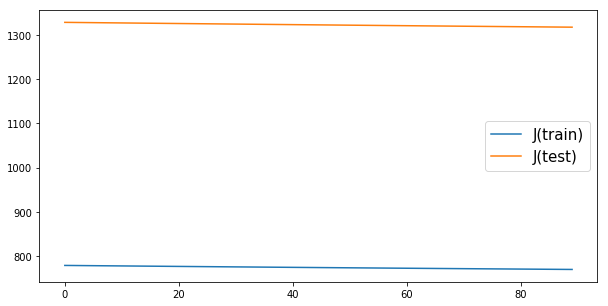

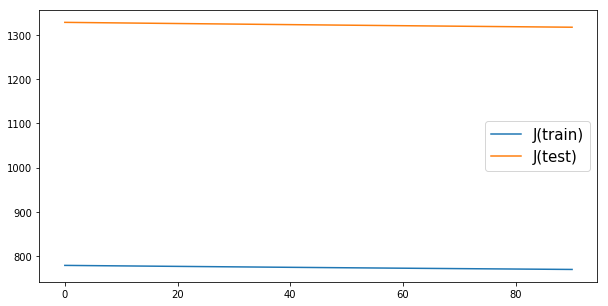

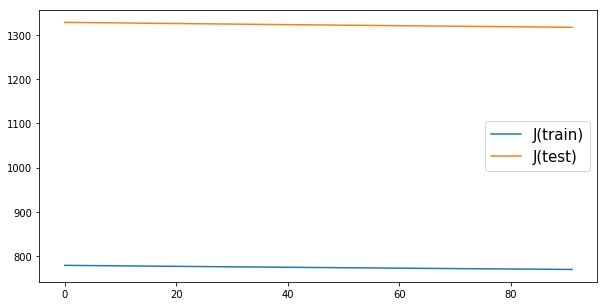

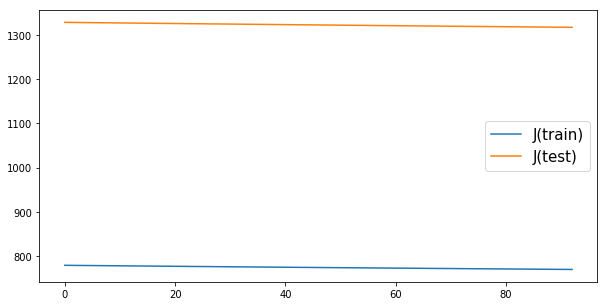

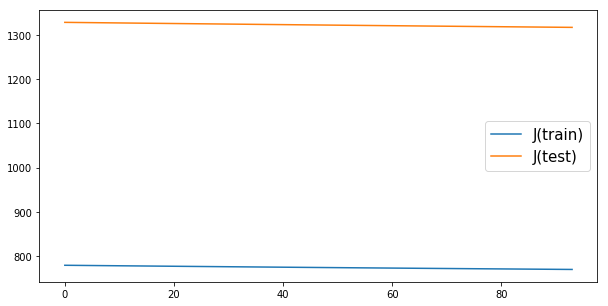

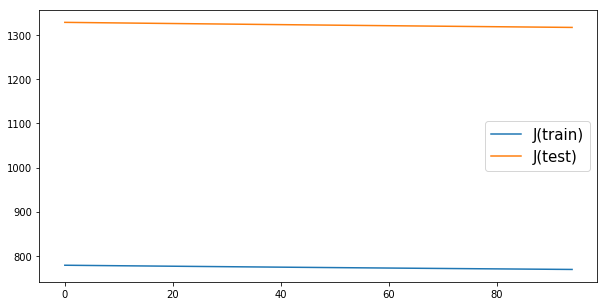

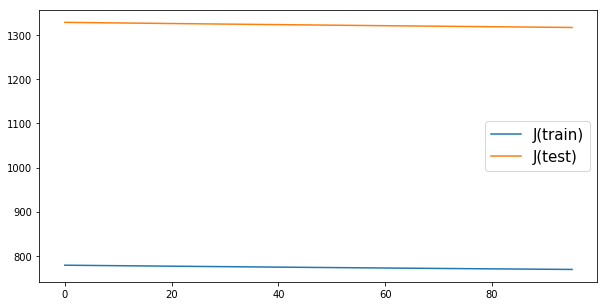

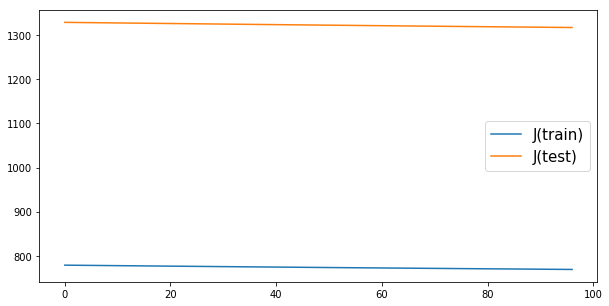

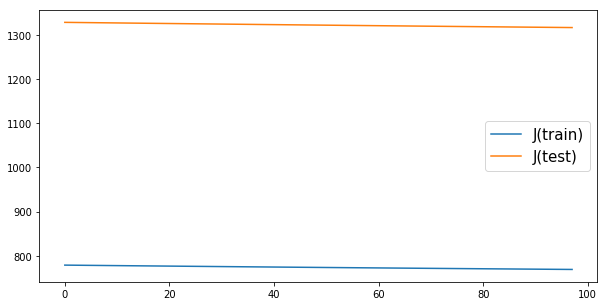

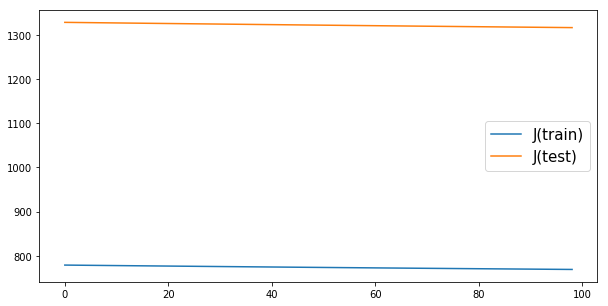

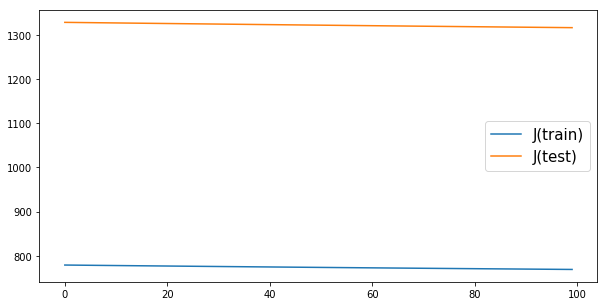

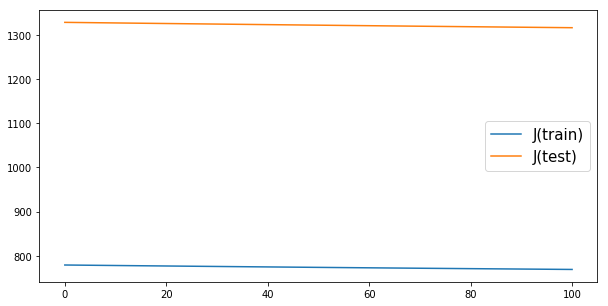

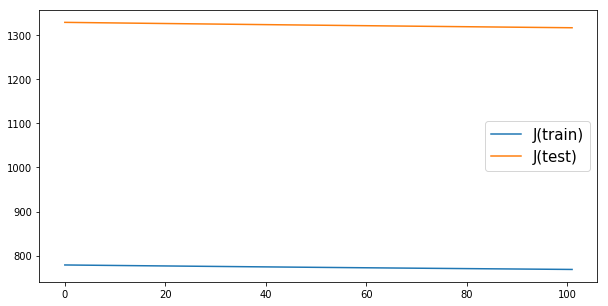

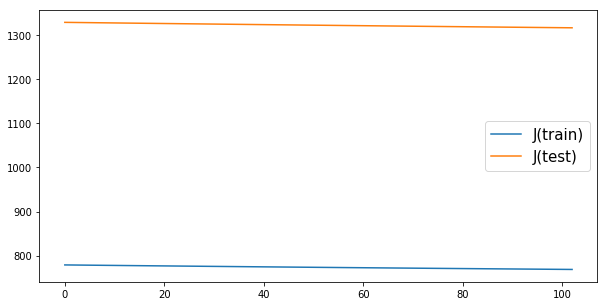

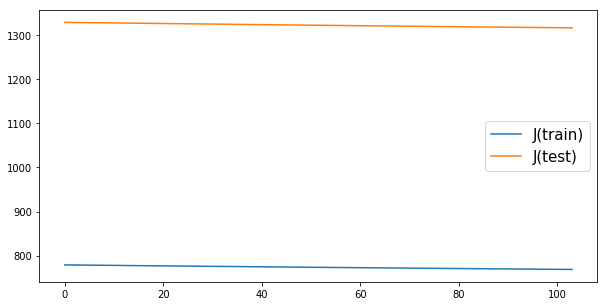

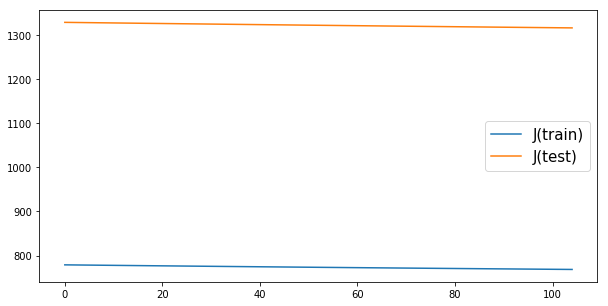

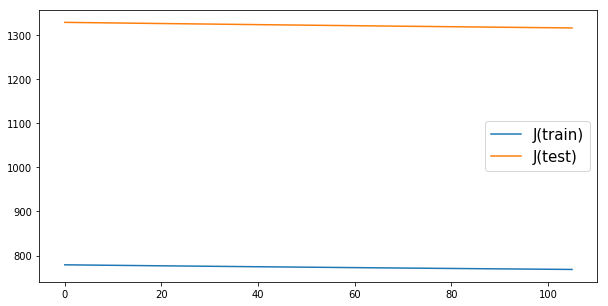

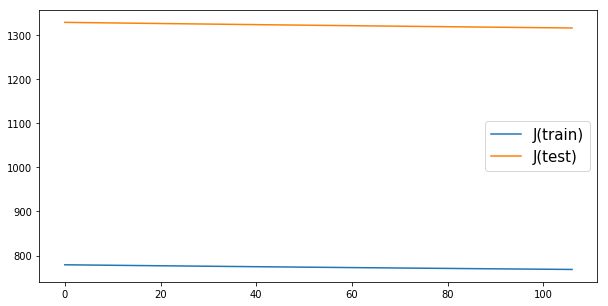

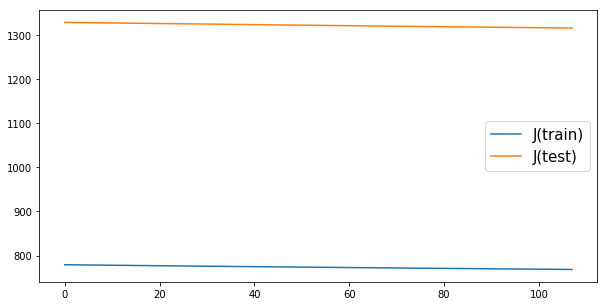

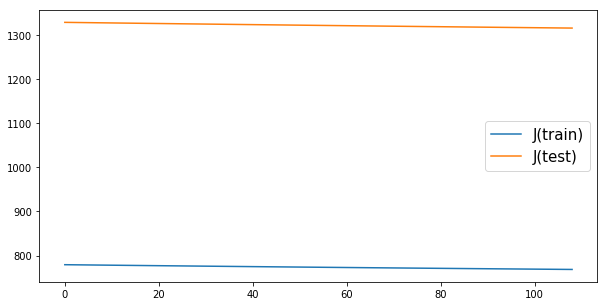

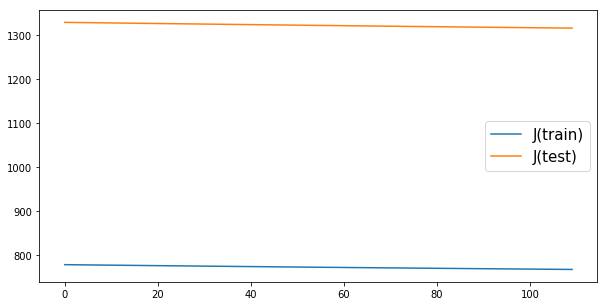

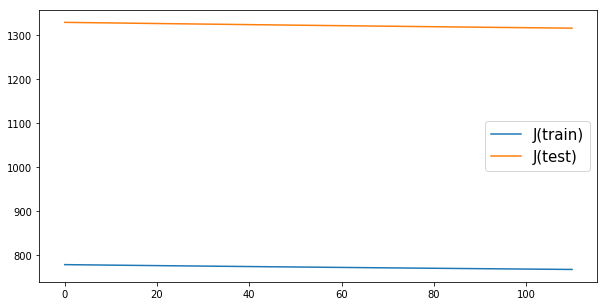

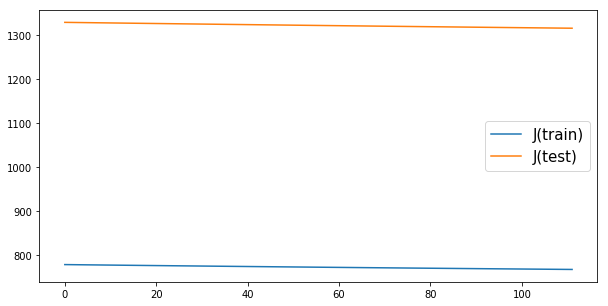

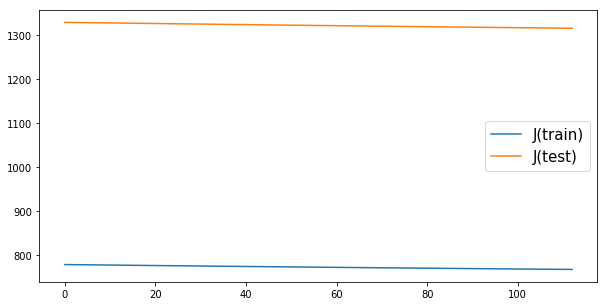

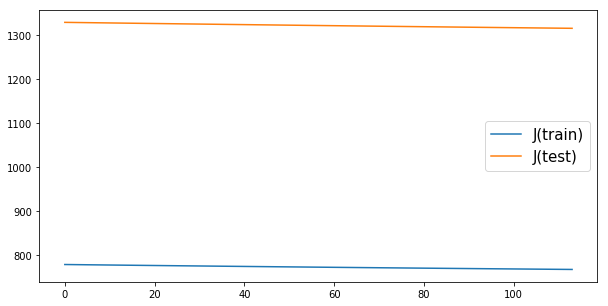

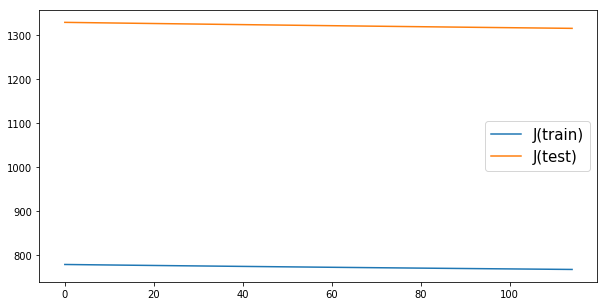

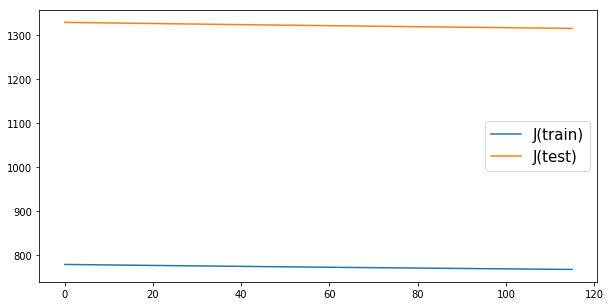

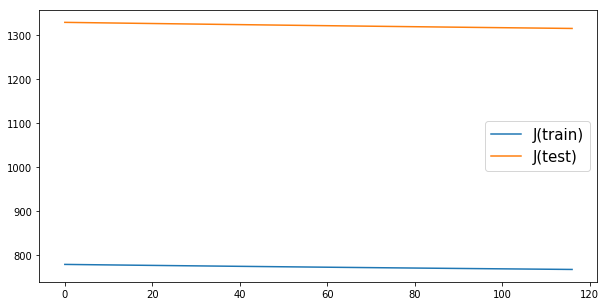

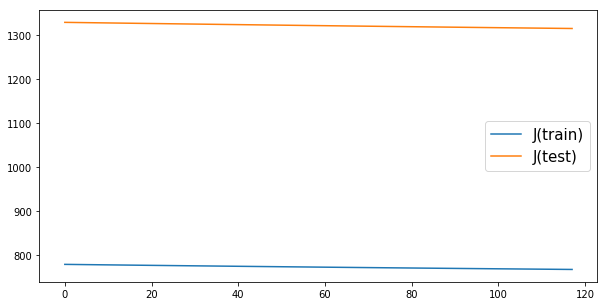

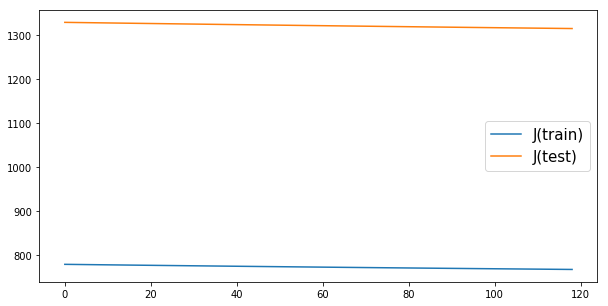

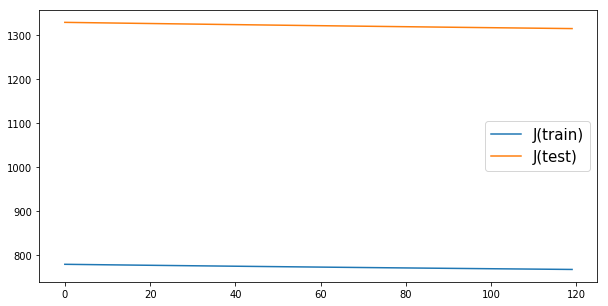

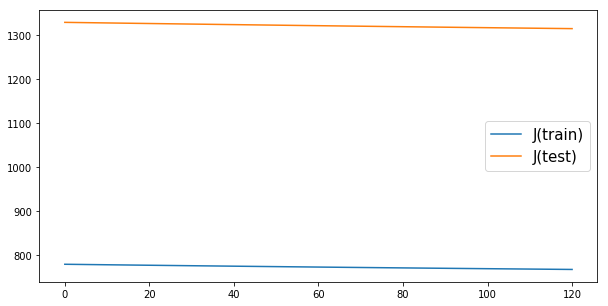

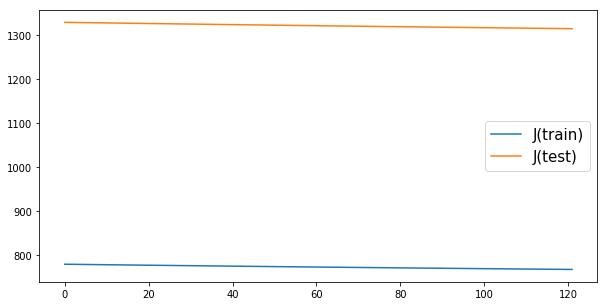

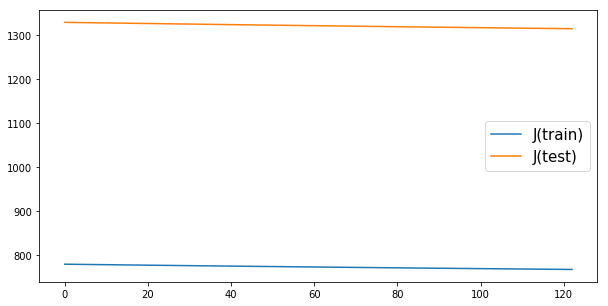

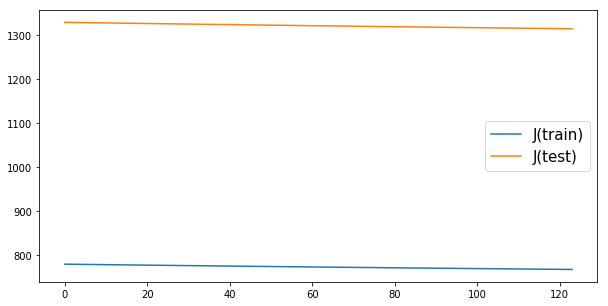

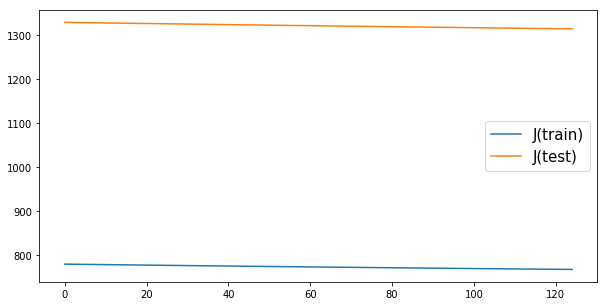

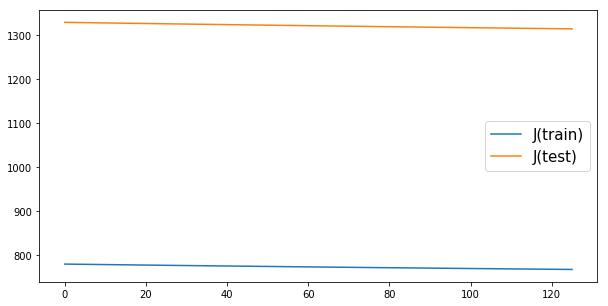

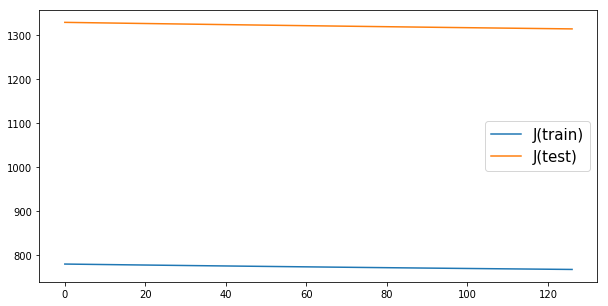

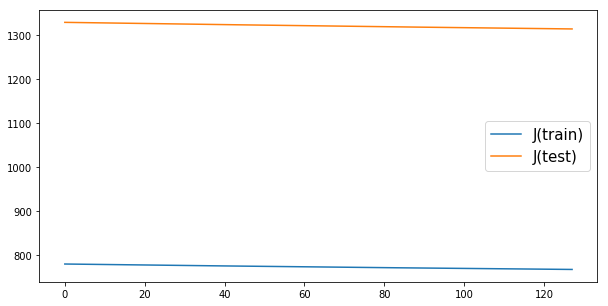

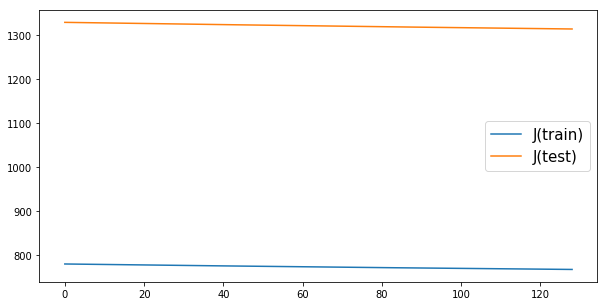

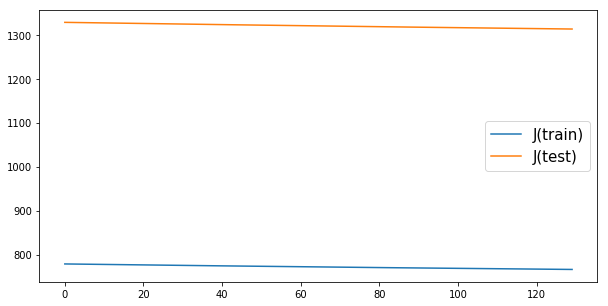

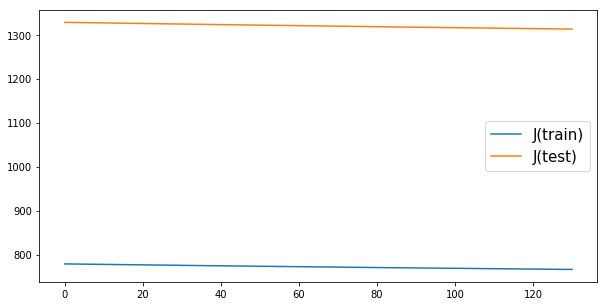

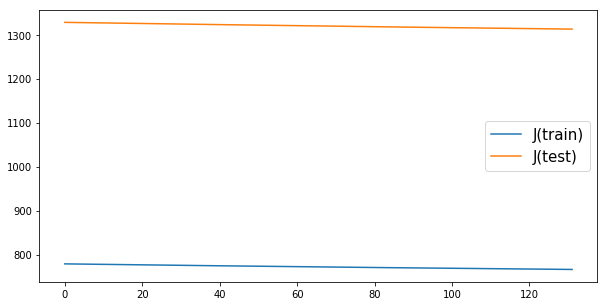

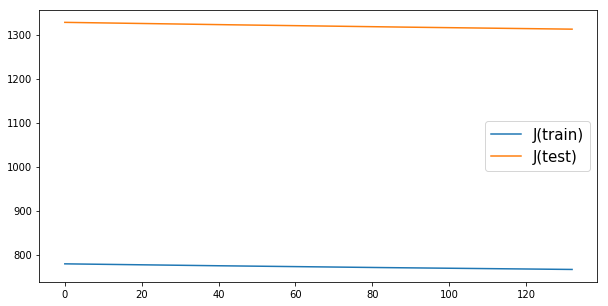

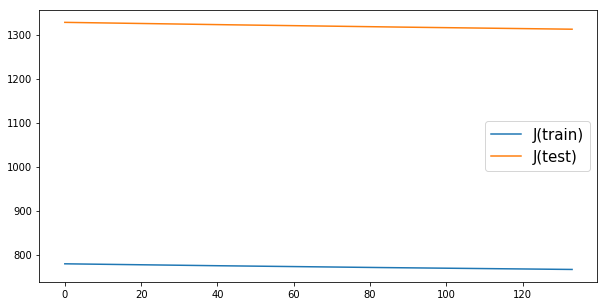

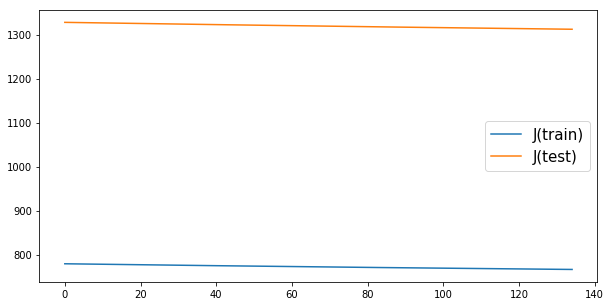

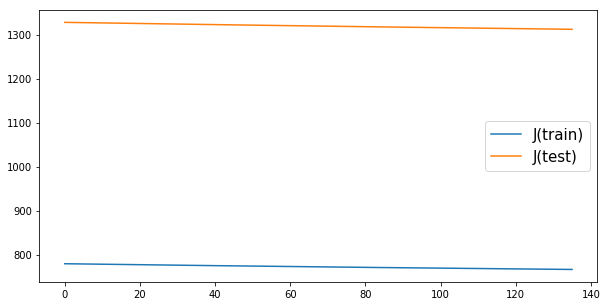

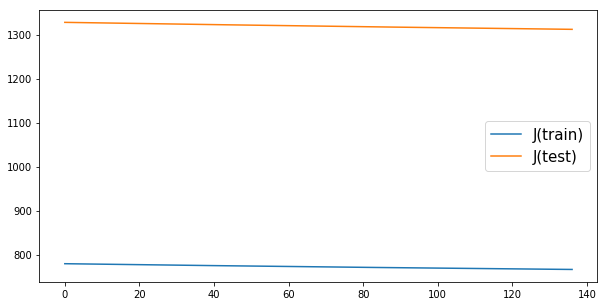

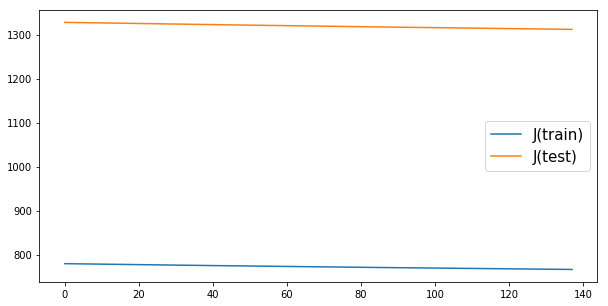

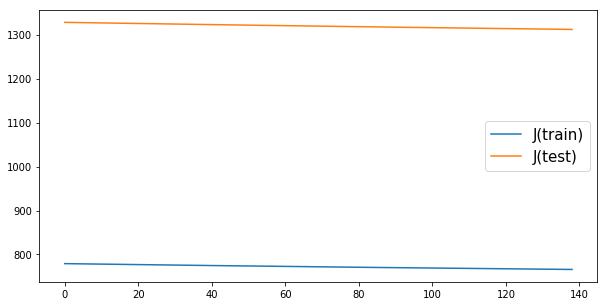

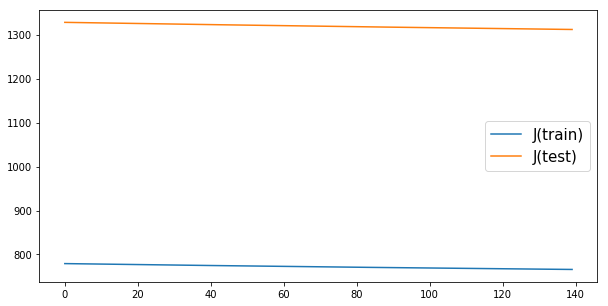

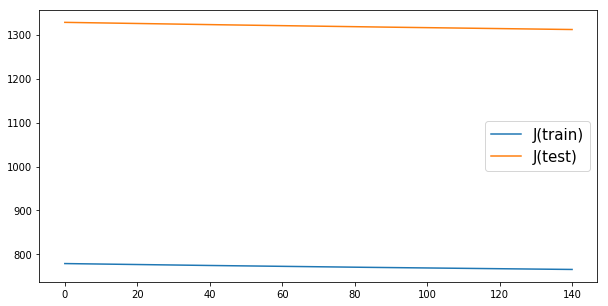

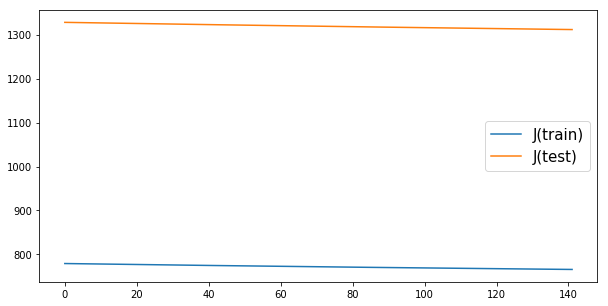

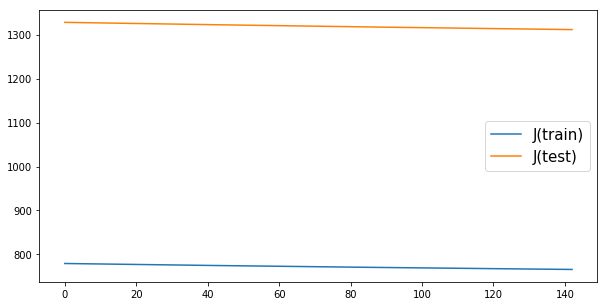

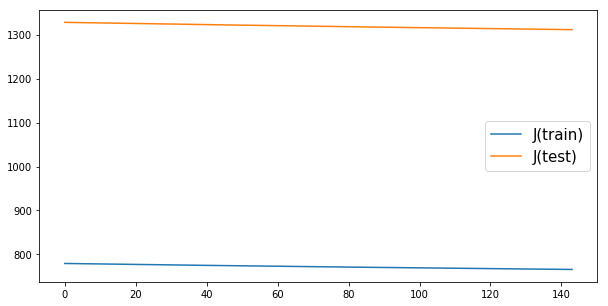

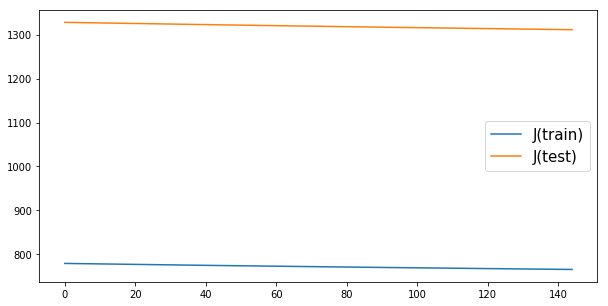

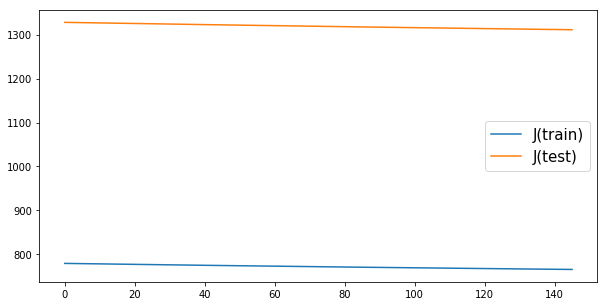

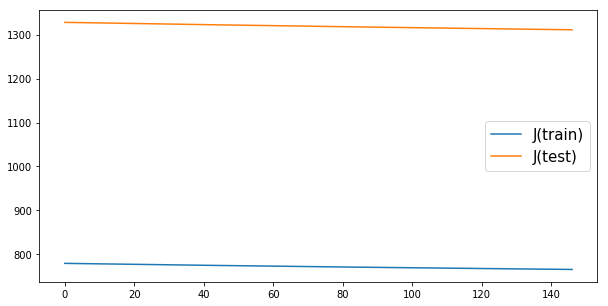

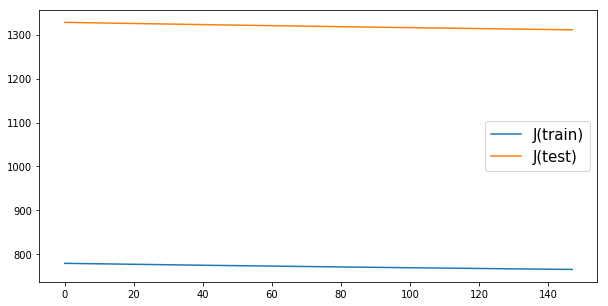

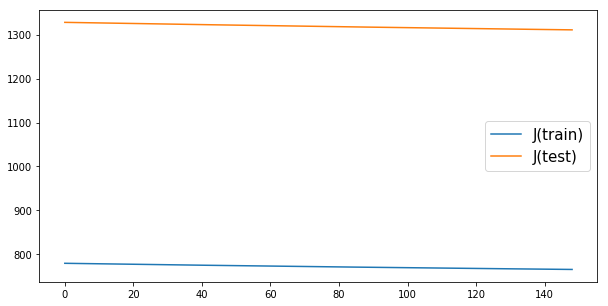

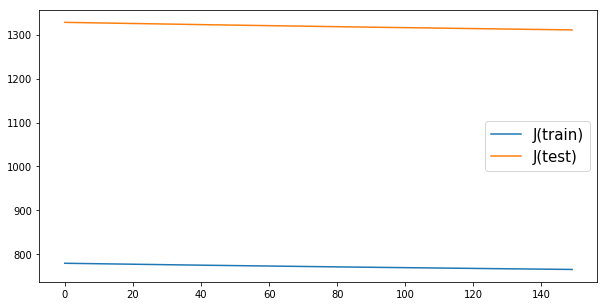

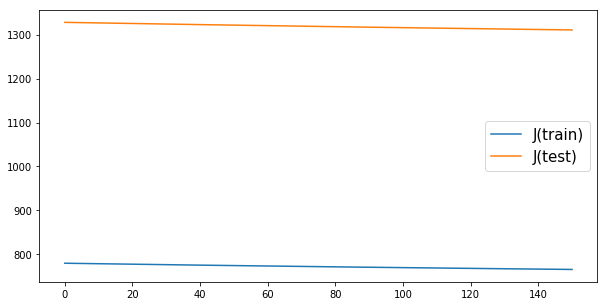

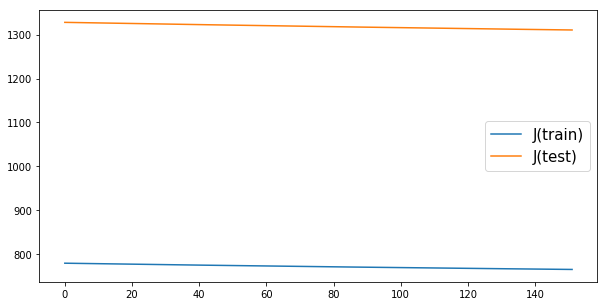

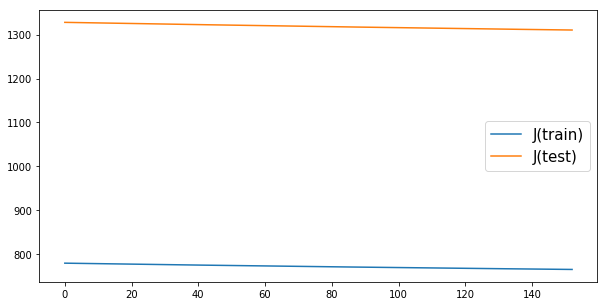

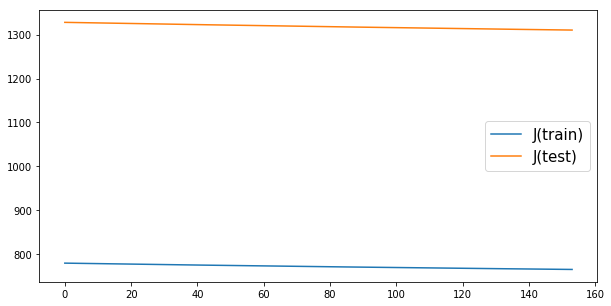

In [30]:
# Now it's time to run the gradient descent, let's parametrize it
alpha = 0.03
epsilon = 0.0001
gradDescentEvol = pd.DataFrame()
count = 0
costFct = 0
plot = True

# and run it! (it's a quite long...)
while np.abs(costFunction(Y_train,yhat) - costFct) >= epsilon * costFct:
    count += 1
    costFct = costFunction(Y_train,yhat)
    theta += gradDescent(X_train,Y_train,yhat,alpha)
    yhat = hypothesis(X_train,theta)
    gradDescentEvol = gradDescentEvol.append(pd.DataFrame({'Jtrain':costFunction(Y_train,yhat),
                                                           'Jtest':costFunction(Y_test,hypothesis(X_test,theta))},
                                                          index = np.arange(1)),
                                             ignore_index=True)
    if plot:
        fig, ax = plt.subplots(figsize=(10,5))
        plotCostFunctionEvol(ax,gradDescentEvol)
        #display.clear_output(wait=True)
        #display.display(plt.gcf())
        time.sleep(1)
        
if not plot:
    fig, ax = plt.subplots(figsize=(10,5))
    plotCostFunctionEvol(ax,gradDescentEvol)

In [31]:
# Afficher les résultats:
print('La descente de gradient a été réalisé en %i étapes.' % count)
print('train_err = %f' % errorFct(Y_train,hypothesis(X_train,theta)))
print('test_err = %f' % errorFct(Y_test,hypothesis(X_test,theta)))

La descente de gradient a été réalisé en 154 étapes.
train_err = 28.256442
test_err = 36.814696


# Regularization

In [32]:
# What about regularization
def regCostFunction(y, yhat, theta, lmb):
    return (np.square(yhat - y).sum() + lmb * np.square(theta).sum()) * (2/y.shape[0])

def regCostFctDeriv(x,y,yhat,theta,lmb):
    return ((yhat - y)*x.T).sum(axis=1)/y.shape[0] + lmb/y.shape[0]*theta

def regGradDescent(x,y,yhat,alpha,theta,lmb):
    return -alpha*regCostFctDeriv(x,y,yhat,theta,lmb)

# On génère aléatoirement le vecteur des paramétres de notre modèle
theta = np.random.rand(X_train.shape[1])-0.5

# Compute cost function value for this initialized model
yhat = hypothesis(X_train,theta)
print("Cost Function value = {}".format(regCostFunction(Y_train,yhat, theta, 0.8)))

Cost Function value = 522016.02971359633


In [33]:
# Now it's time to run the gradient descent, let's parametrize it
alpha = 0.03
epsilon = 0.0001
lmb = 0.5
gradDescentEvol = pd.DataFrame()
count = 0
costFct = 0
plot = False

# and run it! (it's a quite long...)
while np.abs(regCostFunction(Y_train,yhat,theta, lmb) - costFct) >= epsilon*costFct:
    count += 1
    costFct = regCostFunction(Y_train,yhat,theta, lmb)
    theta += regGradDescent(X_train,Y_train,yhat,alpha,theta, lmb)
    yhat = hypothesis(X_train,theta)
    gradDescentEvol = gradDescentEvol.append(pd.DataFrame({'Jtrain':regCostFunction(Y_train,yhat,theta, lmb),
                                                           'Jtest':regCostFunction(Y_test,hypothesis(X_test,theta),theta, lmb)},
                                                          index = np.arange(1)),
                                             ignore_index=True)
    if plot:
        fig, ax = plt.subplots(figsize=(10,5))
        plotCostFunctionEvol(ax,gradDescentEvol)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(1)
        
if not plot:
    fig, ax = plt.subplots(figsize=(10,5))
    plotCostFunctionEvol(ax,gradDescentEvol)
    

KeyboardInterrupt: 

In [ ]:
# Afficher les résultats:
print('La descente de gradient a été réalisé en %i étapes.' % count)
print('train_err = %f' % errorFct(Y_train,hypothesis(X_train,theta)))
print('test_err = %f' % errorFct(Y_test,hypothesis(X_test,theta)))

In [ ]:
data.iloc[0]

In [ ]:
theta